# Load Libraries and Functions

In [6]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Importing Custom Functions
import nbimporter
from Functions import process_text, add_sequential_index, process_label_text, remove_duplicates_nan
from Functions import classify_product_type, nan_info, plot_character_length, convert_to_years, examine_text_outliers
from Functions import process_company_text, clean_manufacturer_text, clean_data, list_to_string


### Test Multiprocessing with Script

In [7]:
def f(x):
    return x*x

# should add if __name__ == '__main__': protection to protect against infinite process creation
if __name__ == '__main__':
    with mp.Pool(5) as pool:
        print(pool.map(f, [1, 2, 3, 4, 5]))

[1, 4, 9, 16, 25]


# API Keys and Passwords

In [8]:
# MySQL password
PASSWORD = "schweini"  # Your Password

# openFDA API Key
openFDAAPI = "E9AA90Q9ntbRnUu0MuXGVPchoquUCFgNhbmZ8pOk"  # Halee
openFDAAPIVicky = "hIh9QVHxR5GsP8A8ffDcoDt2MMRWh3SjeeCV9joF" # Vicky
# Data.Medicaid API Key

In [9]:
# Code to assess performance
# Still need to implement
#from line_profiler import LineProfiler

#def your_function():
    # Your code here


#profiler.add_function(your_function)
#profiler.run('your_function()')
#profiler.print_stats()

# FDA Data

## API Request for Historical Text Documents

https://open.fda.gov/apis/other/historicaldocument/

In [10]:
# Time API call
start_time = time.time() 

# OpenFDA API endpoint for fetching historical documents
BASE_URL = 'https://api.fda.gov/other/historicaldocument.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the API request
params = {
    'limit': 1000,  # Adjust the limit as needed
    'skip': 0,       # Starting point for fetching records
    'search': "year:2012 + year:2013 + year:2014"  # Adjust year as needed
}

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API
def fetch_data():
    documents = []
    
    while True:
        headers = {
            'Authorization': f'Bearer {API_KEY}'
        }
        response = requests.get(BASE_URL, params=params, headers=headers)

        if response.status_code != 200:
            print(f"Failed to fetch data: {response.status_code}")
            break
        
        data = response.json()
        results = data.get('results', [])
        if not results:
            print("No more results found.")
            break

        for item in results:
            doc_type = item.get('doc_type', 'N/A')
            year = item.get('year', 'N/A')
            text = item.get('text', 'N/A')
            document = {'doc_type': doc_type, 'year': year, 'text': text}
            if document not in documents:
                documents.append(document)
        
        params['skip'] += params['limit']
        pause_execution()

        print('.', end='', flush=True)

    return documents

# Fetch the data
documents = fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time}")


.Failed to fetch data: 404

Request Time: 3.1215641498565674


In [6]:
# Save the data to a dataframe
documents_df = pd.DataFrame(documents)
documents_df.head()

,doc_type,year,text
0,pr,2014,FDA NEWS RELEASE\nFor Immediate Release: April...
1,pr,2014,FDA NEWS RELEASE\n\nFor Immediate Release: Apr...
2,pr,2013,FDA NEWS RELEASE\n\nFor Immediate Release: Jul...
3,pr,2013,FDA NEWS RELEASE\n\nFor Immediate Release: Jul...
4,pr,2014,FDA NEWS RELEASE\n\nFor Immediate Release: Apr...


In [7]:
# 8854 documents at time of project creation
documents_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   doc_type  484 non-null    object
 1   year      484 non-null    int64 
 2   text      484 non-null    object
dtypes: int64(1), object(2)
memory usage: 11.5+ KB


In [8]:
# Save csv file to data library
#csv_file_path = 'DataLibrary/raw_documents.csv'
#documents_df.to_csv(csv_file_path, index=False)

## API Request for Adverse Events Data

https://open.fda.gov/apis/drug/event/

In [11]:
# Time the API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug event data
BASE_URL = 'https://api.fda.gov/drug/event.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
# Adjust search terms to filter/limit data
params = {
    'limit': 100,  # Maximum limit per request
    'search': '_exists_:patient.reaction.reactionoutcome AND patient.drug.drugcharacterization:1 AND patient.patientsex:>0 AND primarysource.qualification:<4 AND patient.reaction.reactionoutcome:<6 AND _exists_:patient.patientweight AND _exists_:patient.patientonsetage AND receiptdate:[2022-01-01 TO 2022-06-30]',
}

# Output file path outside of GitHub/Jupyter due to large file size
# Update file name based on data specs
# File will be called from local storage in subsequent code
OUTPUT_FILE = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_events2022.json')

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())
    
# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0
    
    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True
        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }
            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break
            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break
            
            # Write the data to JSON incrementally
            if first_chunk:
                json.dump(results, file)
                first_chunk = False
            else:
                file.write('\n')
                json.dump(results, file)
            count += len(results)
            
            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break
            if not next_url:
                print("No more pages found.")
                break
            pause_execution()
            print('.', end='', flush=True)  # Dots will show progress
    
    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE

# Fetch the data and save it incrementally to a JSON file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

.

KeyboardInterrupt: 

In [12]:
# Read in .json file in chunks
start_time = time.time()

# Path to the JSON file
file_path = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_events2022.json')

# Initialize an empty list to store DataFrames
dfs = []

# Function to read JSON file in chunks
def read_json_in_chunks(file_path, chunk_size=10000):
    with open(file_path, 'r') as file:
        chunk = []
        for line in file:
            try:
                data = json.loads(line)
                chunk.extend(data)
                if len(chunk) >= chunk_size:
                    yield chunk
                    chunk = []
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {file.tell()}: {e}")
        if chunk:
            yield chunk

# Read the JSON file in chunks and process
for chunk in read_json_in_chunks(file_path):
    dfs.append(pd.json_normalize(chunk))

# Concatenate all DataFrames
events2022_df = pd.concat(dfs, ignore_index=True)

# Set 'safetyreportid' as the index
#events2022_df.set_index('safetyreportid', inplace=True)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

# Clean up temporary df list to preserve ram memory
del dfs


Request Time: 0.07565188407897949 seconds


In [13]:
# Display the DataFrame
events2022_df.head()

,safetyreportversion,safetyreportid,primarysourcecountry,occurcountry,transmissiondateformat,transmissiondate,reporttype,serious,seriousnessdeath,seriousnesslifethreatening,...,patient.patientweight,patient.patientsex,patient.reaction,patient.drug,authoritynumb,patient.summary.narrativeincludeclinical,primarysource.literaturereference,patient.patientagegroup,reportduplicate.duplicatesource,reportduplicate.duplicatenumb
0,2,10023591,GB,GB,102,20220423,1,1,2,1,...,67,2,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN
1,2,10023599,GB,GB,102,20220423,1,1,1,2,...,49,2,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN
2,2,10023600,GB,GB,102,20220423,1,1,2,1,...,54,2,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN
3,2,10023601,GB,GB,102,20220424,1,1,2,2,...,60,2,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN
4,2,10023602,GB,GB,102,20220423,1,1,2,2,...,58,2,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# Check dataframe size
events2022_df.shape

(100, 40)

In [15]:
# Check missing info
nan_info(events2022_df)

,column_name,null_count,null_proportion
0,safetyreportversion,0,0.0
1,safetyreportid,0,0.0
2,primarysourcecountry,0,0.0
3,occurcountry,15,15.0
4,transmissiondateformat,0,0.0
5,transmissiondate,0,0.0
6,reporttype,0,0.0
7,serious,0,0.0
8,seriousnessdeath,0,0.0
9,seriousnesslifethreatening,0,0.0


In [16]:
## ONLY USED FOR BETA TESTING Of SMALL SAMPLE ######
# Save the sample data to a CSV file
#csv_file_path = 'DataLibrary/raw_events.csv'
#events_df.to_csv(csv_file_path, index=False)
#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Drug Labels

https://open.fda.gov/apis/drug/label/

In [17]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug label data
BASE_URL = 'https://api.fda.gov/drug/label.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
params = {
    'limit': 100,  # Maximum limit per request
    'search': 'effective_time:[2022-01-01 TO 2022-06-30]'  # Adjust to match date range of FAERS data
}

# Output file path for saving the data
OUTPUT_FILE = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_labels2022.json')

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0
    
    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True
        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }
            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break
            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break
            
            # Write the data to JSON incrementally
            if first_chunk:
                json.dump(results, file)
                first_chunk = False
            else:
                file.write('\n')
                json.dump(results, file)
            count += len(results)
            
            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break
            if not next_url:
                print("No more pages found.")
                break
            pause_execution()
            print('.', end='', flush=True)  # Dots will show progress
    
    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE

# Fetch the data and save it incrementally to a JSON file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

...................................................................................................................No more pages found.

Total records fetched: 11590

Request Time: 259.57876920700073 seconds


In [18]:
# Read in .json file in chunks
start_time = time.time()

# Path to the JSON file
file_path_labels = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_labels2022.json')

# Initialize an empty list to store DataFrames
dfs_labels = []

# Function to read JSON file in chunks
def read_json_in_chunks(file_path, chunk_size=10000):
    with open(file_path, 'r') as file:
        chunk = []
        for line in file:
            try:
                data = json.loads(line)
                chunk.extend(data)
                if len(chunk) >= chunk_size:
                    yield chunk
                    chunk = []
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {file.tell()}: {e}")
        if chunk:
            yield chunk

# Read the JSON file in chunks and process
for chunk in read_json_in_chunks(file_path_labels):
    dfs_labels.append(pd.json_normalize(chunk))

# Concatenate all DataFrames
labels2022_df = pd.concat(dfs_labels, ignore_index=True)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

# Clean up temporary df list to preserve ram memory
del dfs_labels


Request Time: 1.835968017578125 seconds


In [19]:
# Display the first few rows of the DataFrame
labels2022_df.head()

,spl_product_data_elements,active_ingredient,purpose,indications_and_usage,warnings,do_not_use,ask_doctor,ask_doctor_or_pharmacist,stop_use,pregnancy_or_breast_feeding,...,health_care_provider_letter_table,health_claim,user_safety_warnings,cleaning,diagram_of_device,do_not_use_table,statement_of_identity_table,health_claim_table,spl_indexing_data_elements,references_table
0,[basic care acetaminophen Acetaminophen ACETAM...,[Active ingredient (in each caplet) Acetaminop...,[Purpose Pain reliever/fever reducer],[Uses • temporarily relieves minor aches and p...,[Warnings Liver warning: This product contains...,[Do not use • with any other drug containing a...,[Ask a doctor before use if you have liver dis...,[Ask a doctor or pharmacist before use if you ...,[Stop use and ask a doctor if • pain gets wors...,"[If pregnant or breast-feeding, ask a health p...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,[Antibacterial 2X Benzalkonium Chloride WATER ...,[Benzalkonium Chloride - 0.13%],[Purpose: Antibacterial],[Uses for handwashing or decrease bacteria to ...,[For external use only],NaN,NaN,NaN,[Stop use and ask a doctor if irritation or re...,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[Truth Antibacterial Foaming Hand Wash - Unsce...,[Active ingredient Benzalkonium Chloride 0.13%...,[Purpose Antimicrobial],[Uses For hand sanitizing to decrease bacteria...,[Warnings For external use only . When using t...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,[ACTIVE INGREDIENTS LITHIUM BROM],[USES To relieve the symptoms of sleeplessness.],[INDICATIONS Indications: LITHIUM BROM Sleeple...,[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,[ACTIVE INGREDIENTS IODOFORMUM],[USES To relieve the symptoms of cough.],[INDICATIONS Indications: IODOFORMUM Cough],[STOP USE AND ASK DOCTOR If symptoms persist/w...,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
### USED FOR TESTING OF SMALL SAMPLE ONLY##
# Save the data to a CSV file
#csv_file_path = 'DataLibrary/raw_labels.csv'
#labels_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

## API Request for Manufacturer Information (NDC)

In [38]:
# Time API call
start_time = time.time()

# OpenFDA API endpoint for fetching drug data
BASE_URL = 'https://api.fda.gov/drug/ndc.json'

# API Key for authentication
API_KEY = openFDAAPI

# Parameters for the initial API request
params = {
    'limit': 100,  # Maximum limit per request
    'search': 'listing_expiration_date:[2022-01-01 TO 2022-06-30]'  # Search term for listing_expiration_date > 2022-01-01
}

# Output file path for saving the data
OUTPUT_FILE = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_ndc2022.json')

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    time.sleep(0.2727 + 0.1 * random.random())

# Function to fetch data from the OpenFDA API using the Search-After mechanism
def fetch_data():
    next_url = None
    count = 0
    
    # Open the file in write mode and write the header
    with open(OUTPUT_FILE, mode='w') as file:
        first_chunk = True
        while True:
            headers = {
                'Authorization': f'Bearer {API_KEY}'
            }
            if next_url:
                response = requests.get(next_url, headers=headers)
            else:
                response = requests.get(BASE_URL, params=params, headers=headers)
            if response.status_code != 200:
                print(f"Failed to fetch data: {response.status_code}")
                break
            data = response.json()
            results = data.get('results', [])
            if not results:
                print("No more results found.")
                break
            
            # Write the data to JSON incrementally
            if first_chunk:
                json.dump(results, file)
                first_chunk = False
            else:
                file.write('\n')
                json.dump(results, file)
            count += len(results)
            
            # Extract the next URL from the Link header
            next_url = None
            link_header = response.headers.get('Link')
            if link_header:
                links = link_header.split(',')
                for link in links:
                    if 'rel="next"' in link:
                        next_url = link[link.find('<') + 1:link.find('>')]
                        break
            if not next_url:
                print("No more pages found.")
                break
            pause_execution()
            print('.', end='', flush=True)  # Dots will show progress
    
    print(f"\nTotal records fetched: {count}")
    return OUTPUT_FILE

# Fetch the data and save it incrementally to a JSON file
fetch_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

Failed to fetch data: 404

Total records fetched: 0

Request Time: 0.2911248207092285 seconds


In [20]:
# Read in .json file in chunks
start_time = time.time()

# Path to the JSON file
file_path_ndc = os.path.join(os.path.expanduser('~'), 'Downloads', 'drug_ndc2022.json')

# Initialize an empty list to store DataFrames
dfs_ndc = []

# Read the JSON file in chunks and process
for chunk in read_json_in_chunks(file_path_ndc):
    dfs_ndc.append(pd.json_normalize(chunk))

# Concatenate all DataFrames
ndc2022_df = pd.concat(dfs_ndc, ignore_index=True)

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"\nRequest Time: {execution_time} seconds")

# Clean up temporary df list to preserve ram memory
del dfs_ndc

ValueError: No objects to concatenate

In [ ]:
# Display the first few rows of the DataFrame
ndc2022_df.head()

In [ ]:
pd.set_option('display.max_info_columns', 40)
ndc2022_df.info()

In [ ]:
ndc2022_df.shape

In [ ]:
manus_df = ndc2022_df

# National Library of Medicine - Standardized Drug Names and Information

## Function below calls all matches based on all ndc/setid/rxcui from a dataframe, need to create one that essentially finds only missing values only to reduce comp. time. Logic: 
* Find which one of the index variables has the least amount of missing data in table (rxcui, set id, ndc code)
* Check what corresponding variables are missing 
* Call API to get matching data for those values
* Replace missing values based on logic with retrieved data
* Add NDC11 format to all tables to match with prices, or remove last two characters from NDC11 in prices table so string will match with ndc9 or ndc10

## API Request for RxNorm

https://lhncbc.nlm.nih.gov/RxNav/APIs/RxNormAPIs.html

In [39]:
# Function to fetch NDC properties one at a time
def fetch_ndc_properties(var_list):
    url = "https://rxnav.nlm.nih.gov/REST/ndcproperties.json"
    headers = {"Accept": "application/json"}

    ndc_properties = []
    rxcui_result = []
    processed_rxcuis = set()  # Set to track processed rxcuis
    
    # Choose variable with the highest amount of records to get most matches
    for var in var_list:  # Can be rxcui, ndc codes, or spl set IDS, choose one
        
        # Might need to update this part
        # Loop is slowing down processing
        # Removing duplicates at end might be sufficient (already coded below)
        if var in processed_rxcuis:
            #print(f"Skipping already processed rxcui: {var}")
            continue  # Skip if already processed

        params = {"id": var}  # Single code

        try:
            response = requests.get(url, params=params, headers=headers)
            response.raise_for_status()  # Raise an error for bad status codes
            data = response.json()
            properties = data.get("ndcPropertyList", {}).get("ndcProperty", [])

            if not properties:
                continue
                #print(f"No properties found for rxcui: {var}")

            # Filter the required fields
            for item in properties:
                filtered_property = {
                    'ndcItem': item.get('ndcItem'),  # NDC 11 format
                    'ndc9': item.get('ndc9'),
                    'ndc10': item.get('ndc10'),
                    'rxcui': item.get('rxcui'),
                    'splSetIdItem': item.get('splSetIdItem')
                }
                ndc_properties.append(filtered_property)
                rxcui_result.append(item.get('rxcui'))

            # Mark the rxcui as processed
            processed_rxcuis.add(var)

            # Adding a delay to respect the rate limit with randomness
            time.sleep(1 / 18 + 0.1 * random.random())  # 18 requests per second with additional randomness

        except requests.exceptions.RequestException as e:
            #print(f"Request failed for rxcui: {var}, Error: {e}")
            continue  # Skip to the next rxcui if there's an error

        print(f'.', end='', flush=True )

    # Convert to DataFrame
    df_ndc_properties = pd.json_normalize(ndc_properties)
    # Retain only the first instance of each ndc9
    df_cleaned = df_ndc_properties.drop_duplicates(subset='ndc9', keep='first')
    return df_cleaned, rxcui_result

In [40]:
## USED FOR SMALL SAMPLE TESTING ONLY ##

# Save the data to a JSON file
#json_file_path = 'DataLibrary/rxterms_drugs.json'
#with open(json_file_path, 'w') as json_file:
#    json.dump(drugs, json_file, indent=4)

# Save the data to a CSV file
#csv_file_path = 'DataLibrary/rxterms_drugs.csv'
#drugs_df.to_csv(csv_file_path, index=False)

#print(f"Data saved to {csv_file_path} and {json_file_path}")

# ADReCS Database for Standardized Drug and ADR Term Labeling

In [41]:
# load in static files
adrecs_drug = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drug.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [42]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


In [43]:
# 2601 drugs, and 15317 ADR terms
adrecs_drug.shape, adrecs_ont.shape

((2601, 8), (15317, 5))

# Medicaid 

## API Drug Prices - NADAC - 2024 Report - Update to be Last Datasource for the Database - Grab Prices from Final List of NDC Codes contained in Entire Database - Run API Request in Bathces - Need to Program

https://data.medicaid.gov/dataset/99315a95-37ac-4eee-946a-3c523b4c481e#data-table

In [118]:
# Time API Call
start_time = time.time()

# Base URL for the Medicaid API for NADAC data
BASE_URL = 'https://data.medicaid.gov/api/1/datastore/sql'

# Initial SQL query to fetch data with a limit of 500 and initial offset 0
# Queries 2024 Database only
query_template = '[SELECT * FROM f3b5cf6b-07cc-5f75-8d7b-0a1090b3f7e9][LIMIT 500 OFFSET {}]'

# Function to pause execution to avoid overwhelming the server
def pause_execution():
    # Pause execution for a random time 
    time.sleep(1/10 + 0.1 * random.random())

# Function to fetch data from the Medicaid API in batches
def fetch_nadac_data():
    all_data = []  # Initialize an empty list to store all fetched data
    offset = 0  # Starting offset for pagination
    
    while True:  # Loop to fetch data in batches
        # Modify the query to include the current offset for pagination
        query = query_template.format(offset)
        params = {'query': query}  # Set the parameters for the API request

        response = requests.get(BASE_URL, params=params)  # Send the request to the API
        #print(f"Requesting data with offset: {offset}")  # Debugging statement to show current offset
        #print(f"Response status code: {response.status_code}")  # Debugging statement to show response status

        if response.status_code != 200:  # Check if the request was unsuccessful
            print(f"Failed to fetch data: {response.status_code}")  # Debugging statement for error status
            try:
                error_details = response.json()
                print(f"Error message: {error_details.get('message', 'No message provided')}")  # Print the error message
                print(f"Error details: {error_details.get('data', 'No additional data provided')}")  # Print additional error details
            except ValueError:
                print("Failed to decode JSON error response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error

        try:
            data = response.json()  # Parse the response JSON
            #print(f"Raw response data: {data}")  # Debugging statement to show raw response data
            
            if not isinstance(data, list):  # Check if the response is an array
                print("Expected a list but got a different structure.")
                break

            if not data:  # Check if the list is empty
                print("No more results found.")  # Debugging statement to indicate no more data
                break  # Exit the loop if no more data is found

            all_data.extend(data)  # Append the fetched data to the main list
            offset += len(data)  # Increment the offset by the number of records fetched
            #print(f"Fetched {len(data)} records. Total so far: {len(all_data)}")  # Debugging statement to show fetched data count
            print('.', end='', flush=True)
        except ValueError:  # Handle any JSON decoding errors
            print("Failed to decode JSON response.")  # Debugging statement for JSON error
            break  # Exit the loop if there was an error decoding JSON
        
        pause_execution()  # Pause before the next request to avoid overwhelming the server

    return all_data  # Return the collected data

# Fetch the data
prices = fetch_nadac_data()

# Calculate Processing Time to Get All Data
end_time = time.time()
execution_time = end_time - start_time
print(f"Request Time: {execution_time}")

Failed to fetch data: 400
Error message: No datastore storage found for 61c9dcc2a7c358c928d045d967bde470:1703604237.
Error details: No additional data provided
Request Time: 0.9449620246887207


### Get more years to align with FAERS data years - need to do

In [45]:
# 2023

In [46]:
# 2022

In [47]:
# Combine all by year to create one dataframe

In [48]:
# Convert the data to a pandas DataFrame
prices_df = pd.DataFrame(prices)

# Display the first few rows of the DataFrame
prices_df.head()

""


In [49]:
prices_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Empty DataFrame


# Preprocessing

## PreProcess Labels Table

#### Select Columns

In [273]:
labels_df = labels2022_df

labels_table = pd.DataFrame(labels_df, 
                            columns = ["set_id",  # globally unique identifier (GUID) for the labeling
                                       "effective_time",
                                       #"inactive_ingredient",  # Included in spl_product_data_elements
                                       "purpose",
                                       "warnings",  # Combine text with contraindications and precautions
                                        #"questions",  # Too much missing data
                                       "spl_product_data_elements",  # Contains both active and inactive ingredients
                                        #"version",  # Label version, not needed since ndc code captures this information
                                        #"package_label_principal_display_panel",  # Package label text, redundant information
                                        #"active_ingredient",  # Included in spl_product_data_elements
                                        "openfda.brand_name",  # Combine into list with generic
                                        "openfda.generic_name",  # Combine into list with brand
                                        "openfda.manufacturer_name",  # Company that produces the drug
                                        #"openfda.product_type",  # Denotes whether OTC and prescription, and human or animal, redundant with events
                                        "openfda.substance_name",  # Combine with brand and generic
                                        "openfda.unii",  # Unique ingredient, do not tokenize
                                        "openfda.product_ndc",  # Do NOT tokenize, NDC Product code, use as database key, already a list
                                        #"openfda.package_ndc",  # Product NDC code plus one extra number for package type, Redundant
                                        "openfda.rxcui",  # Do NOT tokenize, normed drug code number, retain for database keys
                                        "contraindications",  # Combine with warnings and precautions
                                        "precautions"  # Combine with warnings and contraindications
                                        ])

In [274]:
labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00146b91-008d-4b16-95b0-6077f98821be,20220407,[Purpose Pain reliever/fever reducer],[Warnings Liver warning: This product contains...,[basic care acetaminophen Acetaminophen ACETAM...,[basic care acetaminophen],[ACETAMINOPHEN],[Amazon.com Services LLC],[ACETAMINOPHEN],[362O9ITL9D],[72288-300],[198440],NaN,NaN
1,00179db3-5a76-4724-a848-28e71eb580a6,20220117,[Purpose: Antibacterial],[For external use only],[Antibacterial 2X Benzalkonium Chloride WATER ...,[Antibacterial 2X],[BENZALKONIUM CHLORIDE],[Sante Manufacturing Inc],[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[71020-016],[1046593],NaN,NaN
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,20220426,[Purpose Antimicrobial],[Warnings For external use only . When using t...,[Truth Antibacterial Foaming Hand Wash - Unsce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,20220425,[USES To relieve the symptoms of sleeplessness.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001e5e85-ed03-4a0b-ae48-3a012882233a,20220331,[USES To relieve the symptoms of cough.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## LIST OF UNIQUE DRUG NAMES

In [275]:
# ADDED TO FUNCTIONS file

# drugs are currently in list format, clean to work with
def clean_data(x):
    if isinstance(x, list):
        return ','.join(x)
    elif isinstance(x, str):
        return x  # Handle strings as needed
    else:
        return x  # Handle other types as needed

# match text
def contains_unique_value(text, unique_values_lower):
    matched_texts = []
    text_lower = text.lower()
    for value in unique_values_lower:
        if value in text_lower:
            matched_texts.append(value)
    return matched_texts

### No multiprocessing

In [276]:
start_time = time.time() 
labels_table['openfda.brand_name'] = clean_data(labels_table['openfda.brand_name'])
labels_table['openfda.generic_name'] = clean_data(labels_table['openfda.generic_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.04607081413269043


### Use multiprocessing

In [277]:
start_time = time.time() 

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        openfda_brand_name = pool.map(clean_data, labels_table['openfda.brand_name'])
        openfda_generic_name = pool.map(clean_data, labels_table['openfda.generic_name'])
    labels_table['openfda.brand_name'] = openfda_brand_name
    labels_table['openfda.generic_name'] = openfda_generic_name

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.29467105865478516


In [278]:
labels_table.head()

,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,openfda.unii,openfda.product_ndc,openfda.rxcui,contraindications,precautions
0,00146b91-008d-4b16-95b0-6077f98821be,20220407,[Purpose Pain reliever/fever reducer],[Warnings Liver warning: This product contains...,[basic care acetaminophen Acetaminophen ACETAM...,basic care acetaminophen,ACETAMINOPHEN,[Amazon.com Services LLC],[ACETAMINOPHEN],[362O9ITL9D],[72288-300],[198440],NaN,NaN
1,00179db3-5a76-4724-a848-28e71eb580a6,20220117,[Purpose: Antibacterial],[For external use only],[Antibacterial 2X Benzalkonium Chloride WATER ...,Antibacterial 2X,BENZALKONIUM CHLORIDE,[Sante Manufacturing Inc],[BENZALKONIUM CHLORIDE],[F5UM2KM3W7],[71020-016],[1046593],NaN,NaN
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,20220426,[Purpose Antimicrobial],[Warnings For external use only . When using t...,[Truth Antibacterial Foaming Hand Wash - Unsce...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,20220425,[USES To relieve the symptoms of sleeplessness.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Lithium bromatum LITHIUM BROMIDE SUCROSE LACT...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001e5e85-ed03-4a0b-ae48-3a012882233a,20220331,[USES To relieve the symptoms of cough.],[STOP USE AND ASK DOCTOR If symptoms persist/w...,[Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Extract unique list values

In [279]:
# extract unique list values
unique_brand_names = labels_table['openfda.brand_name'].dropna().unique()
unique_generic_names = labels_table['openfda.generic_name'].dropna().unique()

# combine the brand and generic columns to account for all possibl enames
unique_drug_names = set(unique_brand_names).union(set(unique_generic_names))

# convert to lowercase, could probably just add to clean data function
unique_drug_names = [str(value).lower() for value in unique_drug_names]

### Examine Nulls

In [280]:
labels_nan = nan_info(labels_table)
labels_nan

,column_name,null_count,null_proportion
0,set_id,0,0.000000
1,effective_time,0,0.000000
2,purpose,3566,30.767903
3,warnings,2057,17.748059
4,spl_product_data_elements,0,0.000000
5,openfda.brand_name,6762,58.343399
6,openfda.generic_name,6762,58.343399
7,openfda.manufacturer_name,6762,58.343399
8,openfda.substance_name,6833,58.955997
9,openfda.unii,6832,58.947368


In [281]:
labels_table.shape

(11590, 14)

### Fill in NA values with RxNorm API Request

In [282]:
# NEED TO ADD LOGIC TO CALL API FOR ROWS THAT ARE MISSING CORRESPONDING NDC (RXCUI RETURNED AUTOMATICALLY)
# MAKES SEARCH TIME SMALLER BY SEARCHING FOR LIKE 20% OF DATA MATCHES FOR na rxcui VS. FULL DATASET
df_cleaned, rxcui_result = fetch_ndc_properties(labels_table['set_id'])
df_cleaned.shape

NameError: name 'fetch_ndc_properties' is not defined

### Fix Dtypes

In [283]:
# Update label date
labels_table['effective_time'] = pd.to_datetime(labels_table['effective_time'], format='%Y%m%d')

# Add year column
labels_table['year'] = labels_table['effective_time'].dt.year

### Process Text Columns

In [284]:
# Define text columns
object_columns = labels_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['label_id', 'set_id',
                                      'openfda.product_ndc', 
                                      'openfda.rxcui', 
                                      'openfda.unii'], 
                                     errors='ignore')
labels_table[object_columns] = labels_table[object_columns].astype(str)

## No MultiProcessing

In [285]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
start_time = time.time()

for col in object_columns:
    new_col_name = col + '_processed'
    labels_table[new_col_name] = labels_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

40.17601275444031


## MultiProcessing

In [286]:
start_time = time.time()

if __name__ == '__main__':
     with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            labels_table[new_col_name] = pool.map(process_label_text, labels_table[col])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

11.674353122711182


### Examine all variables for quality, content, and redundancy

In [287]:
#labels_table['spl_product_data_elements_processed'].head(5)

In [288]:
#labels_table['purpose'].head()

In [289]:
#labels_table['purpose_processed'].info()

In [290]:
#labels_table['purpose_processed'].head(5)

In [291]:
#labels_table['warnings'].head()

In [292]:
#labels_table['warnings_processed'].head()

In [293]:
#labels_table['contraindications'].head()

In [294]:
#labels_table['contraindications_processed'].head()

In [295]:
#labels_table['precautions'].head()

In [296]:
#labels_table['precautions_processed'].head()

In [297]:
#labels_table['openfda.brand_name_processed'].head()

In [298]:
#labels_table['openfda.generic_name_processed'].head()

In [299]:
#labels_table['openfda.manufacturer_name_processed'].head()

In [300]:
#labels_table['openfda.product_type_processed'].head()

In [301]:
#labels_table['openfda.substance_name_processed'].head()

In [302]:
#labels_table['openfda.product_ndc'].head()

### Feature Creation for Labels Data

In [303]:
# Add index column
labels_table = add_sequential_index(labels_table,'label_id')

# Combine warnings, contraindications, and precautions text
labels_table['all_warnings_processed'] = labels_table['warnings_processed'] + labels_table['contraindications_processed'] + labels_table['precautions_processed']
# Remove duplicate tokens from combination list
labels_table['all_warnings_processed'] = labels_table['all_warnings_processed'].apply(remove_duplicates_nan)
 
# Combine brand name, generic name, and substance name
labels_table['all_name_processed'] = labels_table['openfda.brand_name_processed'] + labels_table['openfda.generic_name_processed'] + labels_table['openfda.substance_name_processed']
# Remove duplicate tokens to retain unique descriptors only
labels_table['all_name_processed'] = labels_table['all_name_processed'].apply(remove_duplicates_nan)

In [304]:
# Remove duplicates from purpose text
labels_table['purpose_processed'] = labels_table['purpose_processed'].apply(remove_duplicates_nan)

In [305]:
labels_table.head()

,label_id,set_id,effective_time,purpose,warnings,spl_product_data_elements,openfda.brand_name,openfda.generic_name,openfda.manufacturer_name,openfda.substance_name,...,warnings_processed,spl_product_data_elements_processed,openfda.brand_name_processed,openfda.generic_name_processed,openfda.manufacturer_name_processed,openfda.substance_name_processed,contraindications_processed,precautions_processed,all_warnings_processed,all_name_processed
0,1,00146b91-008d-4b16-95b0-6077f98821be,2022-04-07,['Purpose Pain reliever/fever reducer'],['Warnings Liver warning: This product contain...,['basic care acetaminophen Acetaminophen ACETA...,basic care acetaminophen,ACETAMINOPHEN,['Amazon.com Services LLC'],['ACETAMINOPHEN'],...,"[warning, liver, product, contains, acetaminop...","[basic, care, acetaminophen, croscarmellose, s...","[basic, care, acetaminophen, basic care, care ...",[acetaminophen],"[amazon, com, service, llc, amazon com, com se...",[acetaminophen],<NA>,<NA>,NaN,"[basic, care acetaminophen, care, acetaminophe..."
1,2,00179db3-5a76-4724-a848-28e71eb580a6,2022-01-17,['Purpose: Antibacterial'],['For external use only'],['Antibacterial 2X Benzalkonium Chloride WATER...,Antibacterial 2X,BENZALKONIUM CHLORIDE,['Sante Manufacturing Inc'],['BENZALKONIUM CHLORIDE'],...,"[external, use, external use]","[antibacterial, 2x, benzalkonium, chloride, wa...","[antibacterial, 2x, antibacterial 2x]","[benzalkonium, chloride, benzalkonium chloride]","[sante, manufacturing, inc, sante manufacturin...","[benzalkonium, chloride, benzalkonium chloride]",<NA>,<NA>,NaN,"[chloride, 2x, antibacterial 2x, benzalkonium,..."
2,3,001aa754-65e3-4c5a-91f5-71a3d809be0c,2022-04-26,['Purpose Antimicrobial'],['Warnings For external use only . When using ...,['Truth Antibacterial Foaming Hand Wash - Unsc...,nan,nan,nan,nan,...,"[warning, external, use, using, product, avoid...","[truth, antibacterial, foaming, hand, wash, un...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
3,4,001cc8c5-3b3b-456f-8b62-46da8202ea49,2022-04-25,['USES To relieve the symptoms of sleeplessnes...,['STOP USE AND ASK DOCTOR If symptoms persist/...,['Lithium bromatum LITHIUM BROMIDE SUCROSE LAC...,nan,nan,nan,nan,...,"[stop, use, ask, doctor, symptom, persist, wor...","[lithium, bromatum, bromide, sucrose, lactose,...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN
4,5,001e5e85-ed03-4a0b-ae48-3a012882233a,2022-03-31,['USES To relieve the symptoms of cough.'],['STOP USE AND ASK DOCTOR If symptoms persist/...,['Iodoformum IODOFORM SUCROSE LACTOSE IODOFORM...,nan,nan,nan,nan,...,"[stop, use, ask, doctor, symptom, persist, wor...","[iodoformum, iodoform, sucrose, lactose, white...",<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,NaN,NaN


### Final List of Features for Labels Data

In [306]:
labels_table = labels_table[['set_id',
                             'label_id',
                             'year',
                             'openfda.product_ndc',
                             'openfda.rxcui',
                             'openfda.unii',
                            'spl_product_data_elements_processed', 
                             'all_warnings_processed', 
                             'openfda.generic_name_processed', 
                            'purpose_processed']]

### Assess Text Field Lengths

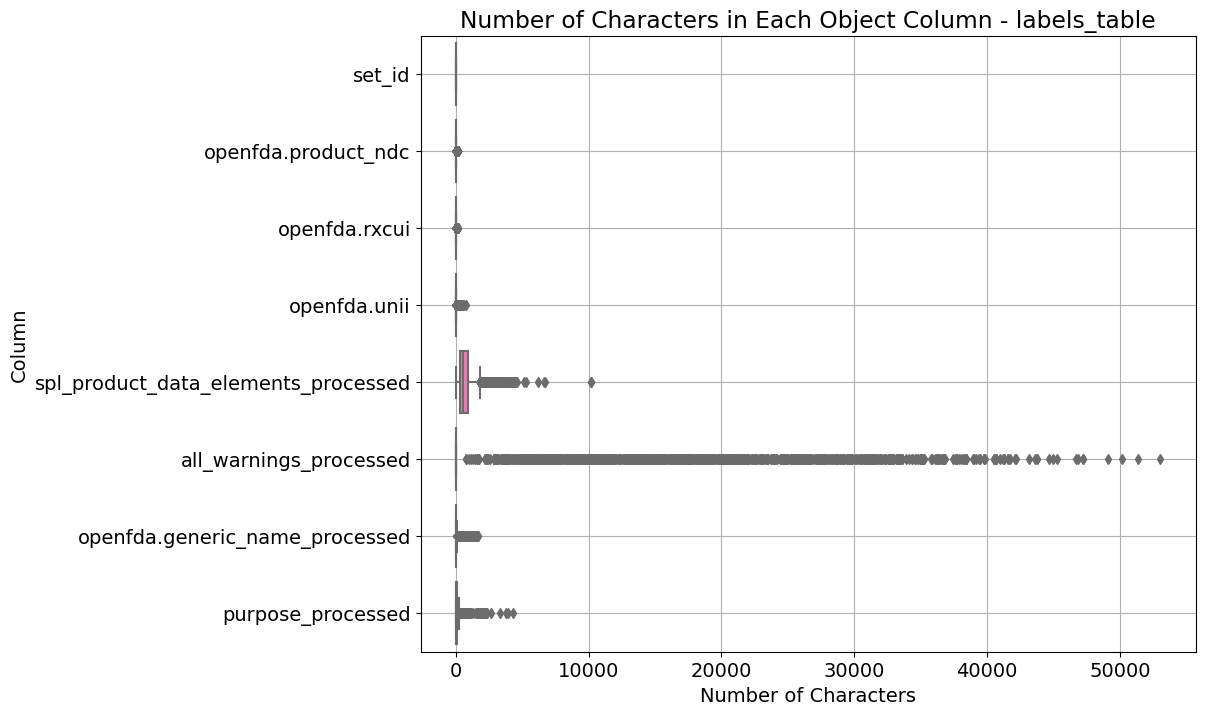


Descriptive Statistics on Character Length:
                                       count         mean          std   min  \
set_id                               11590.0    36.000000     0.000000  36.0   
openfda.product_ndc                  11590.0     9.402502    13.967788   3.0   
openfda.rxcui                        11590.0     6.335203     8.028450   3.0   
openfda.unii                         11590.0    13.033650    29.750260   3.0   
spl_product_data_elements_processed  11590.0   699.555824   583.104606   8.0   
all_warnings_processed               11590.0  2211.172304  6745.308032   3.0   
openfda.generic_name_processed       11590.0    39.201726   112.467793   4.0   
purpose_processed                    11590.0    93.732959   180.139690   4.0   

                                       25%    50%    75%      max  
set_id                                36.0   36.0   36.0     36.0  
openfda.product_ndc                    3.0    3.0   13.0    195.0  
openfda.rxcui                 

In [307]:
plot_character_length(labels_table, 'labels_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [308]:
labels_table_text_processed_outliers = examine_text_outliers(labels_table['all_warnings_processed'])
#print(labels_table_text_processed_outliers.iloc[2])

### Rename Columns

In [309]:
labels_table = labels_table.rename(columns = {'openfda.product_ndc': 'ndc',
                                              'openfda.rxcui': 'rxcui',
                                              'openfda.unii': 'unii',
                         'spl_product_data_elements_processed': 'ingredients',
                         'all_warnings_processed': 'warnings',
                         'openfda.generic_name_processed': 'drug_names',
                         'openfda.manufacturer_name_processed': 'manufacturer',
                         'purpose_processed': 'purpose'})

In [310]:
labels_table.head()

,set_id,label_id,year,ndc,rxcui,unii,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,[72288-300],[198440],[362O9ITL9D],"[basic, care, acetaminophen, croscarmellose, s...",NaN,[acetaminophen],"[purpose, pain reliever, fever, reliever, reli..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,[71020-016],[1046593],[F5UM2KM3W7],"[antibacterial, 2x, benzalkonium, chloride, wa...",NaN,"[benzalkonium, chloride, benzalkonium chloride]","[purpose, purpose antibacterial, antibacterial]"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,NaN,NaN,NaN,"[truth, antibacterial, foaming, hand, wash, un...",NaN,<NA>,"[purpose, antimicrobial, purpose antimicrobial]"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,NaN,NaN,NaN,"[lithium, bromatum, bromide, sucrose, lactose,...",NaN,<NA>,"[relieve, symptom sleeplessness, relieve sympt..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,NaN,NaN,NaN,"[iodoformum, iodoform, sucrose, lactose, white...",NaN,<NA>,"[relieve, cough, relieve symptom, us, symptom,..."


### Convert Lists to Text

In [317]:
columns_to_convert = ['ndc', 'rxcui', 'ingredients', 'drug_names', 'purpose', 'warnings', 'unii']


#FUNCTION HAS BEEN MOVED TO FUNCTIONS FILE
# def list_to_string(lst):
#     if isinstance(lst, list):
#         return ', '.join(lst)
#     else:
#         return lst  # Handle non-list values if any

# Apply function to convert lists to strings for each column
for col in columns_to_convert:
    labels_table[col] = labels_table[col].apply(list_to_string)


In [318]:
labels_table.head()

,set_id,label_id,year,ndc,rxcui,unii,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,72288-300,198440,362O9ITL9D,"basic, care, acetaminophen, croscarmellose, so...",NaN,acetaminophen,"purpose, pain reliever, fever, reliever, relie..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,71020-016,1046593,F5UM2KM3W7,"antibacterial, 2x, benzalkonium, chloride, wat...",NaN,"benzalkonium, chloride, benzalkonium chloride","purpose, purpose antibacterial, antibacterial"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,NaN,NaN,NaN,"truth, antibacterial, foaming, hand, wash, uns...",NaN,<NA>,"purpose, antimicrobial, purpose antimicrobial"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,NaN,NaN,NaN,"lithium, bromatum, bromide, sucrose, lactose, ...",NaN,<NA>,"relieve, symptom sleeplessness, relieve sympto..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,NaN,NaN,NaN,"iodoformum, iodoform, sucrose, lactose, white,...",NaN,<NA>,"relieve, cough, relieve symptom, us, symptom, ..."


In [319]:
labels_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11590 entries, 0 to 11589
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   set_id       11590 non-null  object
 1   label_id     11590 non-null  int64 
 2   year         11590 non-null  int64 
 3   ndc          4828 non-null   object
 4   rxcui        3384 non-null   object
 5   unii         4758 non-null   object
 6   ingredients  11590 non-null  object
 7   warnings     1451 non-null   object
 8   drug_names   4828 non-null   object
 9   purpose      7855 non-null   object
dtypes: int64(2), object(8)
memory usage: 905.6+ KB


#### Truncate Column Lengths

In [324]:
labels_table['warnings'] = labels_table['warnings'].apply(lambda x: x[:20000] if isinstance(x, str) else x)
labels_table['ingredients'] = labels_table['ingredients'].apply(lambda x: x[:5000] if isinstance(x, str) else x)
labels_table['set_id'] = labels_table['set_id'].apply(lambda x: x[:100] if isinstance(x, str) else x)
labels_table['unii'] = labels_table['unii'].apply(lambda x: x[:150] if isinstance(x, str) else x)
labels_table['purpose'] = labels_table['purpose'].apply(lambda x: x[:2200] if isinstance(x, str) else x)


In [326]:
## FOR TESTING SMALL SAMPLE ONLY ##
# Write the DataFrame to a CSV file
labels_table.to_csv('DataLibrary/labels_table.csv', index=False)

## PreProcess Events Table

In [322]:
events2022_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 40 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   safetyreportversion                       100 non-null    object
 1   safetyreportid                            100 non-null    object
 2   primarysourcecountry                      100 non-null    object
 3   occurcountry                              85 non-null     object
 4   transmissiondateformat                    100 non-null    object
 5   transmissiondate                          100 non-null    object
 6   reporttype                                100 non-null    object
 7   serious                                   100 non-null    object
 8   seriousnessdeath                          100 non-null    object
 9   seriousnesslifethreatening                100 non-null    object
 10  seriousnesshospitalization                100 non-n

#### Select Columns

In [159]:
events_table = pd.DataFrame(events2022_df, 
                            columns = ["safetyreportid", #case report number
                                        "transmissiondate", # date the record was created
                                        "serious", # seriousness - 1 = result in death, lifethreatening,hospital,etc. 2 = not in the above
                                        "fulfillexpeditecriteria",  # 1 - Yes, 2 - No
                                        "primarysource.qualification",  # 1-MD, 2-Pharmacist, 3-Health Prof, 4-Lawyer, 5-Consumer/NonHealth
                                        "safetyreportversion",  # Indicates updated reports, with 1 being first, and increasing numbers as new 
                                        "companynumb",  # Company making report
                                        "seriousnessdeath", # 1 = death,
                                       "seriousnessdisabling",  # 1 = disabled
                                       "seriousnessother",  # 1 = other
                                       "seriousnesshospitalization",  # 1 = hospitalized
                                       "seriousnesslifethreatening",  # 1 = life threatening
                                       "duplicate",  # Duplicate status
                                       #"reportduplicate.duplicatesource",  # source of duplicate report
                                        #  "receivedateformat", #always YYYYMMDD
                                        #  "receivedate", #date report received by FDA
                                        "primarysource.reportercountry", # country of the reporter of this event
                                        "patient.patientonsetage", # age of patient when event occured
                                        "patient.patientonsetageunit",  # 801: Y, 802: M, 803: W, 804: D, 805: H 
                                        "patient.patientsex", # sex of patient. 0=unknown, 1=male, 2=female
                                       "patient.patientweight",  # Weight of patient in kg
                                        "patient.reaction", # Dictionary list - expanded as seperate table
                                        "patient.drug"]) # Dictionary list - expanded as separate table
                                        # "patient.patientagegroup", #1 = neonate, 2 = infant, 3=child, 4=adolescent, 5=adult, 6=elderly
                                        # "patient.patientweight", # weight in kg
                                        # "seriousnesscongentialanomali", # 1 if congenital anomaly (fetal abnormality),absent otherwise
                                        # "authoritynumb", #regulatory authority case #
                                        # "reportduplicate"
                                      

#### Fix Dtypes

In [160]:
events_table['transmissiondate'] = pd.to_datetime(events_table['transmissiondate'], format='%Y%m%d')
# Convert Date to Year
events_table['year'] = events_table['transmissiondate'].dt.year

#events_table['fulfillexpeditecriteria'] = events_table['fulfillexpeditecriteria'].astype(int)

#events_table['duplicate'].replace({np.nan: None}, inplace=True)
#events_table['duplicate'] = events_table['duplicate'].astype(pd.Int64Dtype())

#events_table['primarysource.qualification'].replace({np.nan: None}, inplace=True)
#events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(pd.Int64Dtype())

#events_table['patient.patientonsetage'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientonsetage'] = events_table['patient.patientonsetage'].astype(pd.Int64Dtype())

#events_table['patient.patientonsetageunit'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientonsetageunit'] = events_table['patient.patientonsetageunit'].astype(pd.Int64Dtype())

#events_table['patient.patientsex'].replace({np.nan: None}, inplace=True)
#events_table['patient.patientsex'] = events_table['patient.patientsex'].astype(pd.Int64Dtype())


### Standardize Age - NEED TO CHECK THIS - REPORTING NAN FOR AGE

In [161]:
events_table['patient.patientonsetage'] = events_table.apply(lambda row: convert_to_years(row['patient.patientonsetage'], row['patient.patientonsetageunit']), axis=1)
events_table.drop(columns=['patient.patientonsetageunit'], inplace=True)
events_table.head(1)

,safetyreportid,transmissiondate,serious,fulfillexpeditecriteria,primarysource.qualification,safetyreportversion,companynumb,seriousnessdeath,seriousnessdisabling,seriousnessother,seriousnesshospitalization,seriousnesslifethreatening,duplicate,primarysource.reportercountry,patient.patientonsetage,patient.patientsex,patient.patientweight,patient.reaction,patient.drug,year
0,10023591,2022-04-23,1,1,1,2,GB-PERRIGO-14GB002712,2,2,1,1,1,1,GB,NaN,2,67,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2022


### Assessing Weight - supposed to be in KG but looks like some might be LBS

(array([4., 7., 4., 6., 6., 6., 3., 2., 3., 4., 3., 2., 3., 2., 3., 2., 3.,
        3., 3., 3., 3., 2., 3., 2., 4., 3., 3., 2., 3., 3.]),
 array([ 0. ,  2.5,  5. ,  7.5, 10. , 12.5, 15. , 17.5, 20. , 22.5, 25. ,
        27.5, 30. , 32.5, 35. , 37.5, 40. , 42.5, 45. , 47.5, 50. , 52.5,
        55. , 57.5, 60. , 62.5, 65. , 67.5, 70. , 72.5, 75. ]),
 <BarContainer object of 30 artists>)

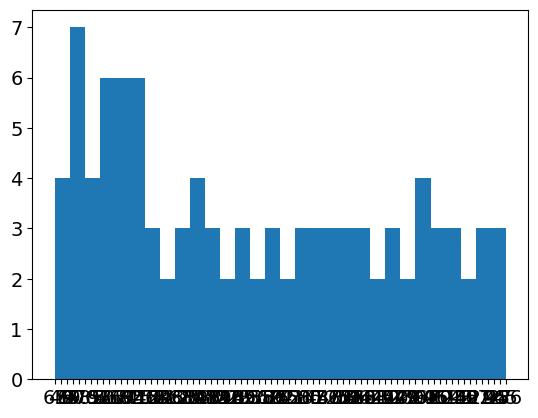

In [162]:
plt.hist(events_table['patient.patientweight'], bins = 30)

### Feature Engineering

In [163]:
events_table = add_sequential_index(events_table,'event_id')

#### Combining Levels of Seriousness into 3-Level Variable (death, serious, non-serious)

In [164]:
# Serious prior to mapping
events_table['serious'].value_counts()

1    94
2     6
Name: serious, dtype: int64

In [165]:
# Update seriousness categories into levels
events_table['seriousnessdeath']=events_table['seriousnessdeath'].replace({'2': '0'}).fillna('0').astype(str)
events_table['seriousnessdisabling']=events_table['seriousnessdisabling'].replace({'2': '0', '1': '2'}).fillna('0').astype(str)
events_table['seriousnesshospitalization']=events_table['seriousnesshospitalization'].replace({'2': '0', '1': '3'}).fillna('0').astype(str)
events_table['seriousnesslifethreatening']=events_table['seriousnesslifethreatening'].replace({'2': '0', '1': '4'}).fillna('0').astype(str)
events_table['seriousnessother']=events_table['seriousnessother'].replace({'2': '0', '1': '5'}).fillna('0').astype(str)
events_table['serious'] = events_table['serious'].replace({'2': '6', '1': '0'}).astype(str)

In [166]:
events_table['seriousnessdeath'].value_counts()

0    84
1    16
Name: seriousnessdeath, dtype: int64

In [167]:
events_table['seriousnessdisabling'].value_counts()

0    92
2     8
Name: seriousnessdisabling, dtype: int64

In [168]:
events_table['seriousnesshospitalization'].value_counts()

3    65
0    35
Name: seriousnesshospitalization, dtype: int64

In [169]:
events_table['seriousnesslifethreatening'].value_counts()

0    85
4    15
Name: seriousnesslifethreatening, dtype: int64

In [170]:
events_table['seriousnessother'].value_counts()

5    61
0    39
Name: seriousnessother, dtype: int64

In [171]:
events_table['serious'].value_counts()

0    94
6     6
Name: serious, dtype: int64

In [172]:
# String pattern denoting outcome
events_table['serious_outcome'] = events_table[['seriousnessdeath',
                                                'seriousnessdisabling',
                                                'seriousnesshospitalization',
                                                'seriousnesslifethreatening',
                                               'seriousnessother',
                                               'serious']].sum(axis=1)

In [173]:
# If string contains "1" - ultimately death, if any number 2-5 - serious, else non-serious

def process_serious_outcome(value):
    if pd.isna(value):  # Check if the value is NaN
        return 0  # Or whatever default value you prefer for NaNs
    str_value = str(value)  # Convert to string
    if str_value == "000006":
        return 0
    elif "1" in str_value:
        return 2
    else:
        return 1

events_table['serious_outcome'] = events_table['serious_outcome'].apply(process_serious_outcome)

In [174]:
events_table['serious_outcome'] = events_table['serious_outcome'].replace({2: 'Death', 1: 'Serious', 0: 'NonSerious'})

In [175]:
events_table['serious_outcome'].value_counts()

Serious    84
Death      16
Name: serious_outcome, dtype: int64

In [176]:
events_table['serious_outcome'].value_counts(normalize = True)

Serious    0.84
Death      0.16
Name: serious_outcome, dtype: float64

### Check for Report Duplicates - openFDA return only most recent report

In [177]:
# Check for safety report # duplicates
duplicates = events_table.duplicated(subset=['safetyreportid']).sum()

print("Duplicates: ", duplicates) 

Duplicates:  0


In [178]:
events_table[['safetyreportid', 'safetyreportversion', 'duplicate']].head(5)

,safetyreportid,safetyreportversion,duplicate
0,10023591,2,1
1,10023599,2,1
2,10023600,2,1
3,10023601,2,1
4,10023602,2,1


### Examine and Handle Nulls

In [179]:
events_nan = nan_info(events_table)
events_nan

,column_name,null_count,null_proportion
0,event_id,0,0.0
1,safetyreportid,0,0.0
2,transmissiondate,0,0.0
3,serious,0,0.0
4,fulfillexpeditecriteria,0,0.0
5,primarysource.qualification,0,0.0
6,safetyreportversion,0,0.0
7,companynumb,7,7.0
8,seriousnessdeath,0,0.0
9,seriousnessdisabling,0,0.0


In [180]:
sex_value_counts = events_table['patient.patientsex'].value_counts()
print(sex_value_counts)

## ONLY KNOWN/REPORTED SEX RETRIEVED IN API REQUEST ##

#For sex, 0=unknown, 1=male, 2=female. fill missing values with 0.
#events_table['patient.patientsex'] = events_table['patient.patientsex'].fillna(0)

2    59
1    41
Name: patient.patientsex, dtype: int64


### Filter Events for Quality Data
* Remove events that have consumer and lawyer reports
* Verify that API called only most recent version of reports

In [181]:
## THIS FILTER APPLIED IN INITIAL API REQUEST ##

# Drop NaN values in 'primarysource.qualification'
#events_table.dropna(subset=['primarysource.qualification'], inplace=True)

# Convert 'primarysource.qualification' to integer
#events_table['primarysource.qualification'] = events_table['primarysource.qualification'].astype(int)

# Filter out values 4 and 5
#events_table = events_table[~events_table['primarysource.qualification'].isin([4, 5])]

#events_table.shape

In [182]:
# Verified that version control exists in API request
events_table[['safetyreportid', 'safetyreportversion']].head(10)

,safetyreportid,safetyreportversion
0,10023591,2
1,10023599,2
2,10023600,2
3,10023601,2
4,10023602,2
5,10023606,2
6,10051458,3
7,10085951,5
8,10143932,4
9,10149169,2


In [183]:
events_table.dtypes

event_id                                  int64
safetyreportid                           object
transmissiondate                 datetime64[ns]
serious                                  object
fulfillexpeditecriteria                  object
primarysource.qualification              object
safetyreportversion                      object
companynumb                              object
seriousnessdeath                         object
seriousnessdisabling                     object
seriousnessother                         object
seriousnesshospitalization               object
seriousnesslifethreatening               object
duplicate                                object
primarysource.reportercountry            object
patient.patientonsetage                 float64
patient.patientsex                       object
patient.patientweight                    object
patient.reaction                         object
patient.drug                             object
year                                    

### Rename Columns

In [184]:
# Rename some columns
events_table = events_table.rename(columns={
    'primarysource.reportercountry': 'country',
    'patient.patientsex': 'sex',
    'patient.patientonsetage': 'age',
    'patient.patientweight': 'weight',
    'patient.reaction': 'reaction',
    'patient.drug': 'drug',
    #'transmissiondate': 'event_year',
    'fulfillexpeditecriteria': 'expedited',
    'primarysource.qualification': 'report_source',
    'companynumb': 'company'
})

In [185]:
#pd.reset_option('display.max_colwidth')
events_table.head()

,event_id,safetyreportid,transmissiondate,serious,expedited,report_source,safetyreportversion,company,seriousnessdeath,seriousnessdisabling,...,seriousnesslifethreatening,duplicate,country,age,sex,weight,reaction,drug,year,serious_outcome
0,1,10023591,2022-04-23,0,1,1,2,GB-PERRIGO-14GB002712,0,0,...,4,1,GB,NaN,2,67,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2022,Serious
1,2,10023599,2022-04-23,0,1,1,2,GB-PERRIGO-14GB002710,1,0,...,0,1,GB,NaN,2,49,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2022,Death
2,3,10023600,2022-04-23,0,1,1,2,GB-PERRIGO-14GB002711,0,0,...,4,1,GB,NaN,2,54,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2022,Serious
3,4,10023601,2022-04-24,0,1,1,2,GB-PERRIGO-14GB002703,0,0,...,0,1,GB,NaN,2,60,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2022,Serious
4,5,10023602,2022-04-23,0,1,1,2,GB-PERRIGO-14GB002705,0,0,...,0,1,GB,NaN,2,58,"[{'reactionmeddraversionpt': '24.1', 'reaction...","[{'drugcharacterization': '1', 'medicinalprodu...",2022,Serious


In [186]:
events_table.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   event_id                    100 non-null    int64         
 1   safetyreportid              100 non-null    object        
 2   transmissiondate            100 non-null    datetime64[ns]
 3   serious                     100 non-null    object        
 4   expedited                   100 non-null    object        
 5   report_source               100 non-null    object        
 6   safetyreportversion         100 non-null    object        
 7   company                     93 non-null     object        
 8   seriousnessdeath            100 non-null    object        
 9   seriousnessdisabling        100 non-null    object        
 10  seriousnessother            100 non-null    object        
 11  seriousnesshospitalization  100 non-null    object        


### Make new table for PatientDrugs - nested dataframe

#### Without MultiProcessing

In [157]:
start_time = time.time()

expanded_patient_drugs = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['drug']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_drugs.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_drugs_table = pd.concat(expanded_patient_drugs, ignore_index=True)
patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

KeyError: 'drug'

#### With MultiProcessing

In [187]:
start_time = time.time()
expanded_patient_drugs = []
def process_row(row):
    expanded_patient_drugs = []
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'drug' list
    for drug_entry in row['drug']:
        flattened_entry = json_normalize(drug_entry)
        flattened_entry['event_id'] = event_id
        expanded_patient_drugs.append(flattened_entry)
    
    return pd.concat(expanded_patient_drugs, ignore_index=True)

if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Number of CPU cores
    with mp.Pool(num_cores) as pool:
        patient_drugs_list = pool.map(process_row, events_table.to_dict('records'))

    # Concatenate all entries into a new DataFrame
    patient_drugs_table = pd.concat(patient_drugs_list, ignore_index=True)
    patient_drugs_table = patient_drugs_table[['event_id'] + [col for col in patient_drugs_table.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

1.378896951675415


### Make new table for PatientReactions

#### Without MultiProcessing

In [ ]:
start_time = time.time()

expanded_patient_reaction = []

# Iterate through each row of the original DataFrame
for _, row in events_table.iterrows():
    event_id = row['event_id']
    
    # Iterate through each drug entry in 'patient.drug' list
    for drug_entry in row['reaction']:
        # Flatten nested JSON into columns
        flattened_entry = json_normalize(drug_entry)
        
        # Add event_id to the flattened entry
        flattened_entry['event_id'] = event_id
        
        # Append the flattened entry to the list
        expanded_patient_reaction.append(flattened_entry)

# Concatenate all entries into a new DataFrame
patient_reactions_df = pd.concat(expanded_patient_reaction, ignore_index=True)
patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [50]:
start_time = time.time()

def process_row(row):
    expanded_patient_reaction = []
    event_id = row['event_id']
    
    # Iterate through each reaction entry in 'reaction' list
    for reaction_entry in row['reaction']:
        flattened_entry = json_normalize(reaction_entry)
        flattened_entry['event_id'] = event_id
        expanded_patient_reaction.append(flattened_entry)
    
    return pd.concat(expanded_patient_reaction, ignore_index=True)

if __name__ == '__main__':
    num_cores = mp.cpu_count()  # Number of CPU cores

    with mp.Pool(num_cores) as pool:
        # Use pool.map to process each row in parallel
        patient_reactions_list = pool.map(process_row, events_table.to_dict('records'))

    # Concatenate all entries into a new DataFrame
    patient_reactions_df = pd.concat(patient_reactions_list, ignore_index=True)
    patient_reactions_df = patient_reactions_df[['event_id'] + [col for col in patient_reactions_df.columns if col != 'event_id']]
    
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

1.081092119216919


### Remove Drug and Reaction Columns as they are in new tables

In [188]:
events_table.drop(['drug', 'reaction'], axis=1, inplace=True)

### Assess Text Field Lengths

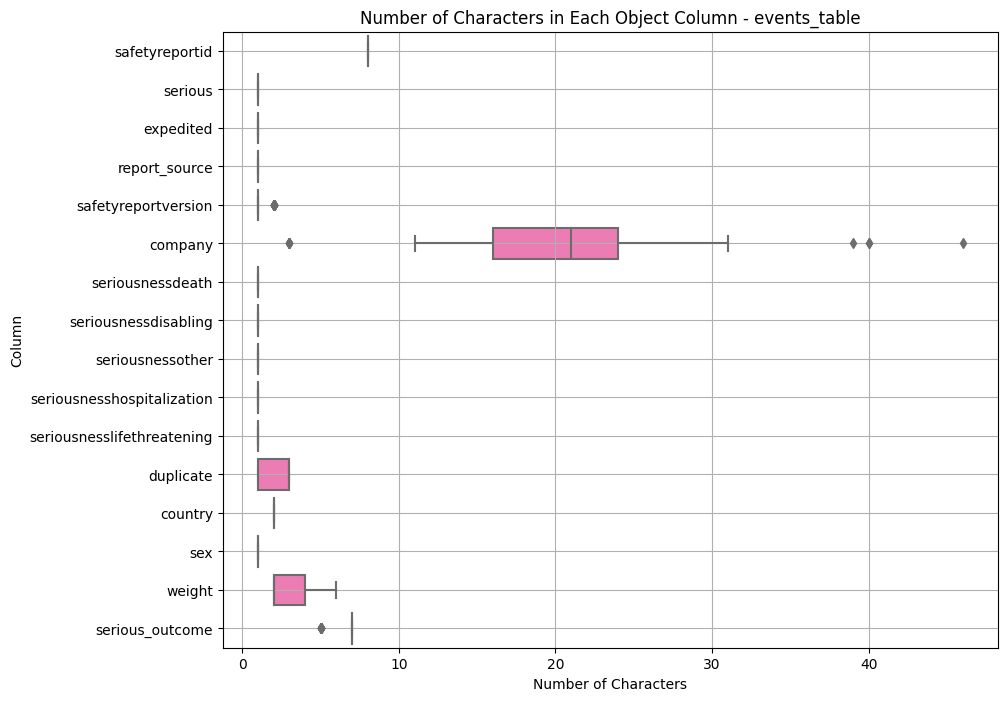


Descriptive Statistics on Character Length:
                            count   mean       std  min   25%   50%   75%  \
safetyreportid              100.0   8.00  0.000000  8.0   8.0   8.0   8.0   
serious                     100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
expedited                   100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
report_source               100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
safetyreportversion         100.0   1.24  0.429235  1.0   1.0   1.0   1.0   
company                     100.0  19.90  7.357399  3.0  16.0  21.0  24.0   
seriousnessdeath            100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
seriousnessdisabling        100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
seriousnessother            100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
seriousnesshospitalization  100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
seriousnesslifethreatening  100.0   1.00  0.000000  1.0   1.0   1.0   1.0   
duplicate                   100

In [52]:
plot_character_length(events_table, 'events_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [53]:
events_table_text_processed_outliers = examine_text_outliers(events_table['company'])
print(events_table_text_processed_outliers.iloc[2])

DE-EISAI MEDICAL RESEARCH-EC-2015-012641


#### Custom Text Processing of Company Information - Retain Name Only

In [54]:
# Creat list of country abbreviations and extra abbreviations to remove from text data
country_codes = events_table['country'].dropna().unique().tolist()
country_codes = [i.lower() for i in country_codes]
country_codes = ['cn' if country == 'canada' else country for country in country_codes]
country_codes = country_codes+["usa", "isr", "ger", "tus", "dklu", "bp", "sp",
                                  "nj", "aus", "deuct", "ve", "pomal", "gbr",
                                  "jacan", "fra", "deu", 'deuct', 'ita',
                              'gw', 'jet', 'aur', 'aut', 'ml',
                              'eut', 'ent', 'sp', 'chn',
                              'jpn', 'kor', 'can', 'europe',
                              'bw', 'rr', 'eu', 'bl', 'deusp',
                              'uki', 'japan', 'teu', 'ind']

extra_abv = ['nldsp', 'usasp', 'company', 'bax', 'spo',
                'ccaza', 'cinry', 'and', 'cansp', 'oxyc',
            'scpr', 'gbrct', 'gbrsp', 'tjp', 'unk',
            'frasp', 'brasp', 'sol', 'cbst','pmco',
            'jpnct', 'frua', 'espct', 'pre',
            'dsu', 'gmbh', 'dse', 'belsp', 'crisp',
            'kdl', 'irlsp', 'mpi', 'avee', 'usani', 
            'sun', 'belct', 'itasp', 'hkgsp', 'argsp']

country_codes_df = pd.DataFrame({'codes': country_codes})

# save list of country codes
country_codes_df.to_csv('DataLibrary/country_codes.csv', index=False)

##### No Multiprocessing

In [55]:
start_time = time.time() 
events_table['company_name'] = events_table['company'].astype(str).apply(process_company_text)
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.06777215003967285


##### With Multiprocessing

In [56]:
# Create a pool with the same number of workers as CPU cores
start_time = time.time() 
if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        company_name = pool.map(process_company_text, events_table['company'])
        events_table['company_name'] = company_name
    # Apply the process_company_row function to each element in the 'company' column in parallel
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.11273503303527832


In [57]:
events_table[['company', 'company_name', 'country']].head(20) 

,company,company_name,country
0,GB-PERRIGO-14GB002712,[perrigo],GB
1,GB-PERRIGO-14GB002710,[perrigo],GB
2,GB-PERRIGO-14GB002711,[perrigo],GB
3,GB-PERRIGO-14GB002703,[perrigo],GB
4,GB-PERRIGO-14GB002705,[perrigo],GB
5,NaN,None,GB
6,US-PFIZER INC-2014087785,"[pfizer, inc]",US
7,US-ROCHE-1110133,[roche],US
8,HU-ABBVIE-14P-076-1228482-00,[abbvie],HU
9,GB-ROCHE-1388410,[roche],GB


In [58]:
# Set display option to show the full list without truncation
pd.set_option('display.max_rows', None)
#events_table['company_name'].value_counts()
# Reset display option to default
#pd.reset_option('display.max_rows')

#### Text Processing of Country Name

In [59]:
# Replace category missing label with NA and Canada
events_table['country'] = events_table['country'].replace({"COUNTRY NOT SPECIFIED": pd.NA, "CANADA": 'CN'})

# Lower case country code text
events_table['country'] = events_table['country'].apply(lambda x: x.lower() if pd.notna(x) else x)

In [60]:
events_table['country'].head(20)

0     gb
1     gb
2     gb
3     gb
4     gb
5     gb
6     us
7     us
8     hu
9     gb
10    jp
11    us
12    il
13    ca
14    ca
15    ca
16    us
17    dk
18    gb
19    us
Name: country, dtype: object

In [61]:
# Drop Cryptic company information
events_table.drop(['company'], axis = 1, inplace = True)

In [62]:
events_table[['company_name', 'country']].head(10) 

,company_name,country
0,[perrigo],gb
1,[perrigo],gb
2,[perrigo],gb
3,[perrigo],gb
4,[perrigo],gb
5,None,gb
6,"[pfizer, inc]",us
7,[roche],us
8,[abbvie],hu
9,[roche],gb


### Reeaxmine Field Lengths

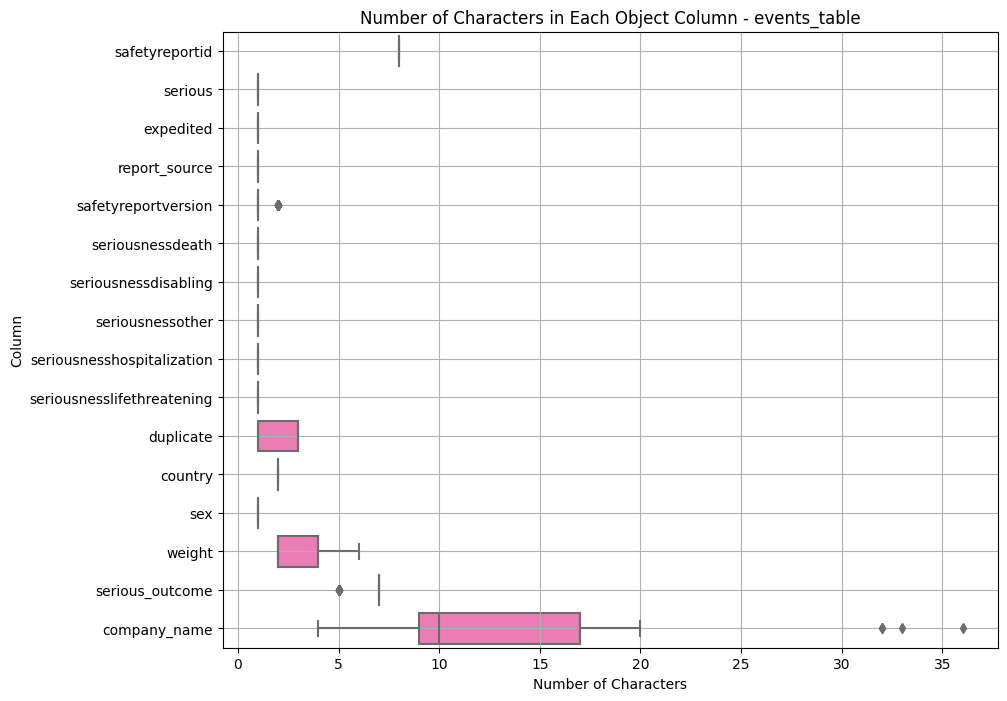


Descriptive Statistics on Character Length:
                            count   mean       std  min  25%   50%   75%   max
safetyreportid              100.0   8.00  0.000000  8.0  8.0   8.0   8.0   8.0
serious                     100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
expedited                   100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
report_source               100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
safetyreportversion         100.0   1.24  0.429235  1.0  1.0   1.0   1.0   2.0
seriousnessdeath            100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
seriousnessdisabling        100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
seriousnessother            100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
seriousnesshospitalization  100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
seriousnesslifethreatening  100.0   1.00  0.000000  1.0  1.0   1.0   1.0   1.0
duplicate                   100.0   2.10  1.000000  1.0  1.0   3.0   3.0   3.0
country

In [63]:
plot_character_length(events_table, 'events_table')

In [64]:
examine_text_outliers(events_table['company_name']).iloc[0:10]

45    [cubist, pharmaceuticals, inc]
64       [glaxosmithkline, inc, gsk]
82        [eisai, medical, research]
99        [eisai, medical, research]
Name: company_name, dtype: object

In [65]:
events_table.dtypes

event_id                               int64
safetyreportid                        object
transmissiondate              datetime64[ns]
serious                               object
expedited                             object
report_source                         object
safetyreportversion                   object
seriousnessdeath                      object
seriousnessdisabling                  object
seriousnessother                      object
seriousnesshospitalization            object
seriousnesslifethreatening            object
duplicate                             object
country                               object
age                                  float64
sex                                   object
weight                                object
year                                   int64
serious_outcome                       object
company_name                          object
dtype: object

#### Choose Final List of Features

In [66]:
events_table = events_table[['event_id',
                            'year',
                            'expedited',
                            'report_source',
                            'country',
                            'age',
                            'sex',
                            'weight',
                            'serious_outcome',
                            'company_name']]

### Convert Lists to Text

In [67]:
# Function to convert list to concatenated string
def list_to_string(lst):
    if isinstance(lst, list):
        return ', '.join(lst)
    else:
        return lst  # Handle non-list values if any

events_table['company_name'] = events_table['company_name'].apply(list_to_string)
#events_table = events_table.drop(columns=['safetyreportversion'])


events_table = events_table.rename(columns={'event_year': 'year'})

In [68]:
# Write the DataFrame to a CSV file
events_table.to_csv('DataLibrary/events_table.csv', index=False)

## PreProcess Patient Drugs Table

In [189]:
patient_drugs_table.head()
patient_drugs_table.columns

Index(['event_id', 'drugcharacterization', 'medicinalproduct',
       'drugauthorizationnumb', 'drugdosagetext', 'drugadministrationroute',
       'drugindication', 'actiondrug', 'drugadditional',
       'activesubstance.activesubstancename', 'openfda.application_number',
       'openfda.brand_name', 'openfda.generic_name',
       'openfda.manufacturer_name', 'openfda.product_ndc',
       'openfda.product_type', 'openfda.route', 'openfda.substance_name',
       'openfda.rxcui', 'openfda.spl_id', 'openfda.spl_set_id',
       'openfda.package_ndc', 'openfda.unii', 'openfda.nui',
       'openfda.pharm_class_moa', 'openfda.pharm_class_cs',
       'openfda.pharm_class_epc', 'drugbatchnumb', 'drugstructuredosagenumb',
       'drugstructuredosageunit', 'drugseparatedosagenumb',
       'drugintervaldosageunitnumb', 'drugintervaldosagedefinition',
       'drugstartdateformat', 'drugstartdate', 'drugdosageform',
       'drugenddateformat', 'drugenddate', 'drugtreatmentduration',
       'drugtrea

#### Select Columns

In [190]:
patient_drugs_table = pd.DataFrame(patient_drugs_table, 
                               columns = [
                                'event_id',  # Identifier for the event
                                'drugcharacterization',  # Level of detail for the drug in the event report
                                'medicinalproduct',  # Name of the drug
                                # 'drugauthorizationnumb',  # Marketing authorization number of the drug
                                # 'drugadministrationroute',  # Route of administration for the drug
                                'drugindication',  # Indication for use of the drug
                                # 'drugbatchnumb',  # Batch number for the drug
                                # 'drugstructuredosagenumb',  # Structured dosage number of the drug
                                # 'drugstructuredosageunit',  # Unit of structured dosage for the drug
                                # 'drugdosagetext',  # Textual description of the dosage for the drug
                                # 'drugstartdateformat',  # Date format for the start date of drug administration
                                # 'drugstartdate',  # Start date of drug administration
                                #'drugrecurreadministration',  # Indicator for recurring drug administration
                                # 'drugadditional',  # Additional details about the drug
                                # 'openfda.application_number',  # FDA application number for the drug
                                # 'openfda.brand_name',  # Brand name for the drug
                                'openfda.generic_name',  # Generic name for the drug
                                'openfda.manufacturer_name',  # Manufacturer name for the drug
                                'openfda.product_ndc',  # NDC (National Drug Code) number for the drug product
                                'openfda.product_type',  # Type of drug product (e.g., HUMAN PRESCRIPTION DRUG)
                                # 'openfda.route',  # Route of administration for the drug
                                # 'openfda.substance_name',  # Substance name associated with the drug
                                'openfda.rxcui',  # RxNorm Concept Unique Identifier (RxCUI) for the drug
                                # 'openfda.spl_id',  # Structured Product Labeling (SPL) ID for the drug
                                'openfda.spl_set_id',  # SPL Set ID for the drug
                                # 'openfda.package_ndc',  # NDC (National Drug Code) number for the drug package
                                # 'openfda.nui',  # NUI (National Uniform Identifier) for the drug
                                # 'openfda.pharm_class_moa',  # Pharmacological class (Mechanism of Action) for the drug
                                # 'openfda.pharm_class_cs',  # Chemical structure class for the drug
                                # 'openfda.pharm_class_epc',  # Pharmacological class (EPC) for the drug
                                'openfda.unii',  # Unique Ingredient Identifier (UNII) for the drug substance
                                # 'actiondrug',  # Action taken with the drug
                                # 'drugdosageform',  # Dosage form of the drug
                                # 'openfda.pharm_class_pe',  # Pharmacological class (Physiologic Effect) for the drug
                                # 'activesubstance.activesubstancename',  # Name of the active substance in the drug
                                # 'drugenddateformat',  # Date format for the end date of drug administration
                                # 'drugenddate',  # End date of drug administration
                                #'drugseparatedosagenumb',  # Separated dosage number for the drug
                                # 'drugintervaldosageunitnumb',  # Interval dosage unit number for the drug
                                # 'drugintervaldosagedefinition',  # Definition of interval dosage for the drug
                                # 'drugcumulativedosagenumb',  # Cumulative dosage number for the drug
                                # 'drugcumulativedosageunit'  # Unit of cumulative dosage for the drug
                            ])


In [191]:
patient_drugs_table.head(5)

,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,openfda.rxcui,openfda.spl_set_id,openfda.unii
0,1,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
1,2,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
2,3,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
3,4,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
4,5,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."


#### Fix Dtypes

In [192]:
patient_drugs_table['drugcharacterization'] = patient_drugs_table['drugcharacterization'].astype(int)

#### Filter for Quality Data

In [193]:
patient_drugs_table['drugcharacterization'].value_counts()

1    673
2    575
3      2
Name: drugcharacterization, dtype: int64

In [194]:
# Add unique ID
patient_drugs_table = add_sequential_index(patient_drugs_table,'patient_drug_id')

# Keep only primary drug suspects
patient_drugs_table = patient_drugs_table.loc[patient_drugs_table['drugcharacterization'] == 1]

#### Examining Variables of Interest
* Drugcharacterization: 1-suspect(drug primary cause), 2-concomitant(drug taken with primary cause), 3-interation(drug interact with primary cause)
* Medicinalproduct: generic or brand name
* Drugindication: official drug purpose
* openfda.rxcui : Rx cui code
* openfda.unii : unique ingredient identifier

In [195]:
patient_drugs_table['drugcharacterization'].value_counts()

1    673
Name: drugcharacterization, dtype: int64

### Examine Nulls

In [196]:
patient_drugs_table_nan_info = nan_info(patient_drugs_table)
patient_drugs_table_nan_info

,column_name,null_count,null_proportion
0,patient_drug_id,0,0.000000
1,event_id,0,0.000000
2,drugcharacterization,0,0.000000
3,medicinalproduct,0,0.000000
4,drugindication,343,50.965825
5,openfda.generic_name,77,11.441308
6,openfda.manufacturer_name,77,11.441308
7,openfda.product_ndc,77,11.441308
8,openfda.product_type,77,11.441308
9,openfda.rxcui,80,11.887073


### Filter for First NDC/RXCUI/ if contains list

In [197]:
patient_drugs_table.head()

,patient_drug_id,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,openfda.rxcui,openfda.spl_set_id,openfda.unii
0,1,1,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
1,2,2,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
2,3,3,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
3,4,4,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
4,5,5,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...","[72288-405, 79481-0302, 50332-0103, 0904-6719,...","[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]","[313782, 198440, 1358837, 307668, 209459, 1148...","[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."


In [198]:
# Extract the first element from lists in 'openfda.product_ndc'
patient_drugs_table['openfda.product_ndc'] = patient_drugs_table['openfda.product_ndc'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Extract the first element from lists in 'openfda.rxcui'
patient_drugs_table['openfda.rxcui'] = patient_drugs_table['openfda.rxcui'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

In [199]:
patient_drugs_table.head()

,patient_drug_id,event_id,drugcharacterization,medicinalproduct,drugindication,openfda.generic_name,openfda.manufacturer_name,openfda.product_ndc,openfda.product_type,openfda.rxcui,openfda.spl_set_id,openfda.unii
0,1,1,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...",72288-405,"[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]",313782,"[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
1,2,2,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...",72288-405,"[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]",313782,"[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
2,3,3,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...",72288-405,"[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]",313782,"[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
3,4,4,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...",72288-405,"[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]",313782,"[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."
4,5,5,1,ACETAMINOPHEN,Product used for unknown indication,"[ACETAMINOPHEN, ACETAMINOPHEN,, ACETAMINOPHEN ...","[Amazon.com Services LLC, Meijer, Inc., HART H...",72288-405,"[HUMAN OTC DRUG, HUMAN PRESCRIPTION DRUG]",313782,"[113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab...","[362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNS..."


### Use RxNorm API to get matching ndc/rxcui/set id for missing values

In [200]:
# Apply function to rows with missing values only to reduce comp. time

In [202]:
manu_list_csv = pd.read_csv('DataLibrary/manus_table.csv')

### Text Processing

#### Without MultiProcessing

In [203]:
# Apply the clean_text function
start_time = time.time()

patient_drugs_table['manu_list'] = patient_drugs_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.07964372634887695


#### With MultiProcessing

In [287]:
start_time = time.time()
if __name__ == '__main__':    
    with mp.Pool(num_cores) as pool:
        # Use pool.map to apply clean_manufacturer_text to each element in parallel
        patient_drugs_table['manu_list'] = pool.map(clean_manufacturer_text, patient_drugs_table['openfda.manufacturer_name'])
end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

6.688836097717285


In [204]:
# Count the number of manufacturers that produce the drug
patient_drugs_table['manu_num'] = patient_drugs_table['manu_list'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [205]:
# Count the number of rxcui associated with drug
patient_drugs_table['rxcui_num'] = patient_drugs_table['openfda.rxcui'].apply(lambda x: len(x) if np.all(pd.notna(x))==True else 0)

In [206]:
patient_drugs_table[['openfda.manufacturer_name', 'manu_list', 'manu_num', 'rxcui_num']].head(10)

,openfda.manufacturer_name,manu_list,manu_num,rxcui_num
0,"[Amazon.com Services LLC, Meijer, Inc., HART H...","[amazon-com-services-, meijer, hart-health, ma...",274,6
1,"[Amazon.com Services LLC, Meijer, Inc., HART H...","[amazon-com-services-, meijer, hart-health, ma...",274,6
2,"[Amazon.com Services LLC, Meijer, Inc., HART H...","[amazon-com-services-, meijer, hart-health, ma...",274,6
3,"[Amazon.com Services LLC, Meijer, Inc., HART H...","[amazon-com-services-, meijer, hart-health, ma...",274,6
4,"[Amazon.com Services LLC, Meijer, Inc., HART H...","[amazon-com-services-, meijer, hart-health, ma...",274,6
5,"[Amazon.com Services LLC, Meijer, Inc., HART H...","[amazon-com-services-, meijer, hart-health, ma...",274,6
6,"[Pfizer Laboratories Div Pfizer Inc, U.S. Phar...","[pfizer-laboratories-div-pfizer-, u-s-pharmace...",2,7
7,"[Genentech, Inc.]",[genentech],1,7
8,"[Genentech, Inc.]",[genentech],1,7
9,"[Genentech, Inc.]",[genentech],1,7


### Cleaning Text Columns

In [207]:
# Define text columns
object_columns = patient_drugs_table.select_dtypes(include=['object']).columns

# Exclude columns that should not be tokenized, index codes
object_columns = object_columns.drop(['openfda.unii', 
                                      'openfda.rxcui', 
                                      'openfda.manufacturer_name', 
                                      'manu_list',
                                     'openfda.spl_set_id'], errors='ignore')
patient_drugs_table[object_columns] = patient_drugs_table[object_columns].astype(str)

#### No multiprocessing

In [208]:
# Apply the clean_text function
start_time = time.time()

for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = patient_drugs_table[col].apply(process_label_text)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.5353279113769531


#### Use multiprocessing to process text columns

In [209]:
# Apply text processing to the selected text columns and add new processed columns to dataframe
# Create a pool with the same number of workers as CPU cores

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        for col in object_columns:
            new_col_name = col + '_processed'
            # Use pool.map to apply process_label_text to each column in parallel
            patient_drugs_table[new_col_name] = pool.map(process_label_text, patient_drugs_table[col])


### Final list of features for Patient Drugs Table

In [210]:
patient_drugs_table = patient_drugs_table[['patient_drug_id',
                                          'event_id',
                                           'openfda.spl_set_id',
                                          #'drugcharacterization',  # Not necessary since table is filtered to value of 1 for all
                                          'drugindication_processed',
                                          'medicinalproduct_processed',
                                          'openfda.generic_name_processed',
                                          'manu_list',
                                          'manu_num',
                                          'openfda.product_type_processed',
                                          'openfda.rxcui',
                                           'rxcui_num',
                                          'openfda.unii'
                                          ]]

### Rename Columns

In [211]:
patient_drugs_table = patient_drugs_table.rename(columns={
    'medicinalproduct_processed': 'med_product',
    'drugindication_processed': 'indication',
    'openfda.generic_name_processed': 'generic_name',
    'manu_list': 'manufacturers',
    'openfda.product_type_processed': 'product_type',
    'openfda.rxcui': 'rxcui',
    'openfda.unii': 'unii',
    'openfda.spl_set_id': 'spl_set_id'
})

In [212]:
patient_drugs_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 673 entries, 0 to 1249
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   patient_drug_id  673 non-null    int64 
 1   event_id         673 non-null    int64 
 2   spl_set_id       596 non-null    object
 3   indication       330 non-null    object
 4   med_product      673 non-null    object
 5   generic_name     596 non-null    object
 6   manufacturers    596 non-null    object
 7   manu_num         673 non-null    int64 
 8   product_type     596 non-null    object
 9   rxcui            593 non-null    object
 10  rxcui_num        673 non-null    int64 
 11  unii             567 non-null    object
dtypes: int64(4), object(8)
memory usage: 68.4+ KB


### Assess Text Field Lengths

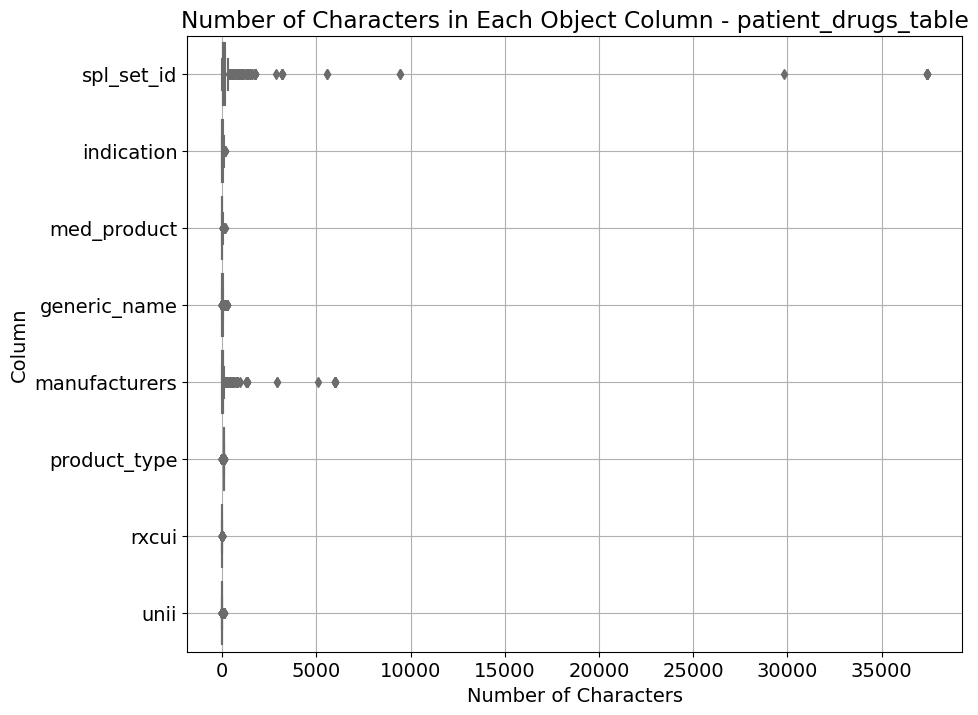


Descriptive Statistics on Character Length:
               count        mean          std  min   25%   50%    75%      max
spl_set_id     673.0  748.515602  4245.555241  3.0  40.0  40.0  160.0  37400.0
indication     673.0   29.768202    33.815541  4.0   4.0   4.0   51.0    125.0
med_product    673.0   15.768202    13.864021  8.0  10.0  11.0   14.0    145.0
generic_name   673.0   27.414562    37.701233  4.0  14.0  14.0   17.0    256.0
manufacturers  673.0  193.912333   713.023135  4.0  13.0  24.0   58.0   5969.0
product_type   673.0   68.172363    23.334779  4.0  76.0  76.0   76.0     95.0
rxcui          673.0    6.196137     0.933910  4.0   6.0   6.0    7.0      7.0
unii           673.0   14.077266     9.964370  3.0  14.0  14.0   14.0     84.0


In [213]:
plot_character_length(patient_drugs_table, 'patient_drugs_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

**Examine 'Manufacturer' Outliers**
Reports contain manufacturers, distributors, and retail

In [214]:
patient_drugs_table_manufacturer_outliers = examine_text_outliers(patient_drugs_table['manufacturers'])
print(patient_drugs_table_manufacturer_outliers.iloc[2])

['amazon-com-services-', 'meijer', 'hart-health', 'major-pharmaceuticals', 'randob-labs', '-dba-crossingwell-consumer-health', 'lil-drug-store-products', 'l-n-k-international', 'amerisource-bergen', 'walmart-see-also-equate-', 'walgreen-company', 'strategic-sourcing-services-', 'kroger-company', 'aptapharma-', 'topco-associates-', 'safeway', 'p-l-development', 'granules-', 'advance-pharmaceutical-', 'meijer-distribution-', 'family-dollar-services-', 'johnson-johnson-consumer-', 'genexa-', 'h-e-b', 'spirit-pharmaceuticals-', 'walgreens', 'lidl-us-', 'chain-drug-consortium', 'kroger-company', 'productos-zapotol-', 'valu-merchandisers-company', 'gelpharma-s-a-de-c-v-', 'target-corporation', 'heb', 'magno-humphries', 'cvs-pharmacy', 'new-world-imports', 'pai-holdings', 'chain-drug-marketing-association', 'cardinal-health-110', '-dba-leader', 'discount-drug-mart', 'walgreens', 'united-natural-foods', '-dba-unfi', 'american-health-packaging', 'time-cap-laboratories', 'rite-aid-corporation', 

#### Convert Lists to Text

In [215]:
columns_to_convert = ['indication', 'med_product', 'manufacturers','generic_name', 'product_type', 'unii', 'spl_set_id']

for col in columns_to_convert:
    patient_drugs_table[col] = patient_drugs_table[col].apply(list_to_string)


#### Set Character Limits

In [216]:
patient_drugs_table['manufacturers'] = patient_drugs_table['manufacturers'].apply(lambda x: x[:5000] if isinstance(x, str) else x)
patient_drugs_table['rxcui'] = patient_drugs_table['rxcui'].apply(lambda x: x[:760] if isinstance(x, str) else x)
patient_drugs_table['generic_name'] = patient_drugs_table['generic_name'].apply(lambda x: x[:300] if isinstance(x, str) else x)
patient_drugs_table['unii'] = patient_drugs_table['unii'].apply(lambda x: x[:150] if isinstance(x, str) else x)
patient_drugs_table['indication'] = patient_drugs_table['indication'].apply(lambda x: x[:150] if isinstance(x, str) else x)

In [217]:
# Write the DataFrame to a CSV file
patient_drugs_table.to_csv('DataLibrary/patient_drugs_table.csv', index=False)

In [218]:
patient_drugs_table.head()

,patient_drug_id,event_id,spl_set_id,indication,med_product,generic_name,manufacturers,manu_num,product_type,rxcui,rxcui_num,unii
0,1,1,"113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab8...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
1,2,2,"113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab8...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
2,3,3,"113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab8...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
3,4,4,"113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab8...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
4,5,5,"113d92bf-f6c9-cc3d-e063-6294a90af033, 1319bab8...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."


## PreProcess Patient Reactions Table

### Rename Columns

In [69]:
patient_reactions_table = patient_reactions_df.rename(columns={
    'reactionmeddrapt': 'reaction',
    'reactionmeddraversionpt': 'version_medDRA',
    'reactionoutcome': 'outcome'
})

### Fix Dtypes

In [70]:
#n/a
#patient_reactions_table.head(10)
#patient_reactions_table.info()

### Feature Engineering

In [71]:
patient_reactions_table = add_sequential_index(patient_reactions_table,'patient_reaction_id')

In [72]:
patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome
0,1,1,24.1,Overdose,1
1,2,1,24.1,Acute hepatic failure,1
2,3,1,24.1,Cytomegalovirus infection,6
3,4,2,24.1,Haemorrhage intracranial,5
4,5,2,24.1,Overdose,5


### Map Features

In [73]:
#map outcomes to text categories

outcome_mapping = {
    1: 'Recovered',
    2: 'Recovering',
    3: 'NotRecovered',
    4: 'RecoveredWithSequelae',
    5: 'Fatal',
    6: 'Unknown'
}

# if outcome is 'Unknown', change to 6 (which will map to unknown again). Necessary that this column is int for mapping
patient_reactions_table.loc[patient_reactions_table['outcome'] == 'Unknown', 'outcome'] = 6

# Perform mapping by outcome mapping
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna(0).astype(int).map(outcome_mapping)

patient_reactions_table.tail()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome
1011,1012,98,24.1,Constipation,Recovered
1012,1013,98,24.1,Therapy cessation,Unknown
1013,1014,99,25.0,Thyroid mass,Recovered
1014,1015,99,25.0,Goitre,Recovered
1015,1016,100,25.0,Haemorrhage,Fatal


## LIST OF UNIQUE REACTIONS

Limit reactions to 64 characters (MySQL column name character length limit).

Filter for top 1000, since MySQL tables can only hold up to 1017 columns. 


In [74]:
# Step 1: Convert all reactions to lowercase
patient_reactions_table['reaction'] = patient_reactions_table['reaction'].str.lower()

# Step 2: Remove reactions with names longer than 64 characters
patient_reactions_table = patient_reactions_table[patient_reactions_table['reaction'].str.len() <= 64]

# Step 3: Get unique values from the 'reaction' column after filtering
unique_reactions_all = patient_reactions_table['reaction'].unique().tolist()

# Step 4: Count occurrences of each remaining reaction
reaction_counts = patient_reactions_table['reaction'].value_counts()

# Step 5: Get the top 1000 most common reactions
top_reactions = reaction_counts.head(1000)

# Step 6: Convert the results into a list of reactions
unique_reactions = top_reactions.index.tolist()

# Print the resulting list of top reactions (Optional)
print(unique_reactions)



['nausea', 'arthralgia', 'fatigue', 'pain', 'vomiting', 'dyspnoea', 'weight increased', 'pain in extremity', 'diarrhoea', 'headache', 'weight decreased', 'drug ineffective', 'off label use', 'nasopharyngitis', 'malaise', 'pyrexia', 'pruritus', 'asthenia', 'decreased appetite', 'dizziness', 'fall', 'insomnia', 'adrenal insufficiency', 'condition aggravated', 'overdose', 'anxiety', 'death', 'acute hepatic failure', 'feeling abnormal', 'hypoaesthesia', 'cough', 'blood pressure decreased', 'arthritis', 'blood pressure increased', 'erythema', 'acute kidney injury', 'depression', 'asthma', 'infusion related reaction', 'contusion', 'osteonecrosis of jaw', 'arthropathy', 'blood pressure systolic increased', 'myalgia', 'productive cough', 'hypersensitivity', 'stress', 'dry skin', 'chest pain', 'pneumonia', 'hyponatraemia', 'therapeutic product effect decreased', 'burning sensation', 'loss of personal independence in daily activities', 'drug hypersensitivity', 'urticaria', 'incorrect dose admini

### Save each reaction as binary column

In [75]:
for reaction in unique_reactions:
    patient_reactions_table[reaction] = 0

# Set the value to 1 if 'reaction' matches the column name
for idx, row in patient_reactions_table.iterrows():
    patient_reactions_table.loc[idx, reaction] = 1

patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome,nausea,arthralgia,fatigue,pain,vomiting,...,helicobacter infection,cardiac arrest,blood test abnormal,psychiatric symptom,hyperhomocysteinaemia,blood pressure fluctuation,prescribed overdose,ankle fracture,carpal tunnel syndrome,goitre
0,1,1,24.1,overdose,Recovered,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,24.1,acute hepatic failure,Recovered,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,24.1,cytomegalovirus infection,Unknown,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,24.1,haemorrhage intracranial,Fatal,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,2,24.1,overdose,Fatal,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
patient_reactions_table.head()

,patient_reaction_id,event_id,version_medDRA,reaction,outcome,nausea,arthralgia,fatigue,pain,vomiting,...,helicobacter infection,cardiac arrest,blood test abnormal,psychiatric symptom,hyperhomocysteinaemia,blood pressure fluctuation,prescribed overdose,ankle fracture,carpal tunnel syndrome,goitre
0,1,1,24.1,overdose,Recovered,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,24.1,acute hepatic failure,Recovered,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,3,1,24.1,cytomegalovirus infection,Unknown,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,24.1,haemorrhage intracranial,Fatal,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,2,24.1,overdose,Fatal,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Text Processing

#### Without MultiProcessing

In [ ]:
#patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)
patient_reactions_table['reaction_processed'] = patient_reactions_table['reaction'].apply(process_label_text)

#### With MultiProcessing

In [78]:
start_time = time.time()

if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        patient_reactions_table['reaction_processed'] = pool.map(process_label_text, patient_reactions_table['reaction'])

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

6.453449010848999


#### Drop unprocessed reaction columns

In [79]:
patient_reactions_table = patient_reactions_table.drop('reaction', axis = 1)

### Examine Nulls

In [80]:
patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info

#fill the missing values in the outcome table with 'Unknown'
patient_reactions_table['outcome'] = patient_reactions_table['outcome'].fillna('Unknown')

patient_reactions_table_nan_info = nan_info(patient_reactions_table)
patient_reactions_table_nan_info


,column_name,null_count,null_proportion
0,patient_reaction_id,0,0.0
1,event_id,0,0.0
2,version_medDRA,0,0.0
3,outcome,0,0.0
4,nausea,0,0.0
5,arthralgia,0,0.0
6,fatigue,0,0.0
7,pain,0,0.0
8,vomiting,0,0.0
9,dyspnoea,0,0.0


### Filter for Data Quality

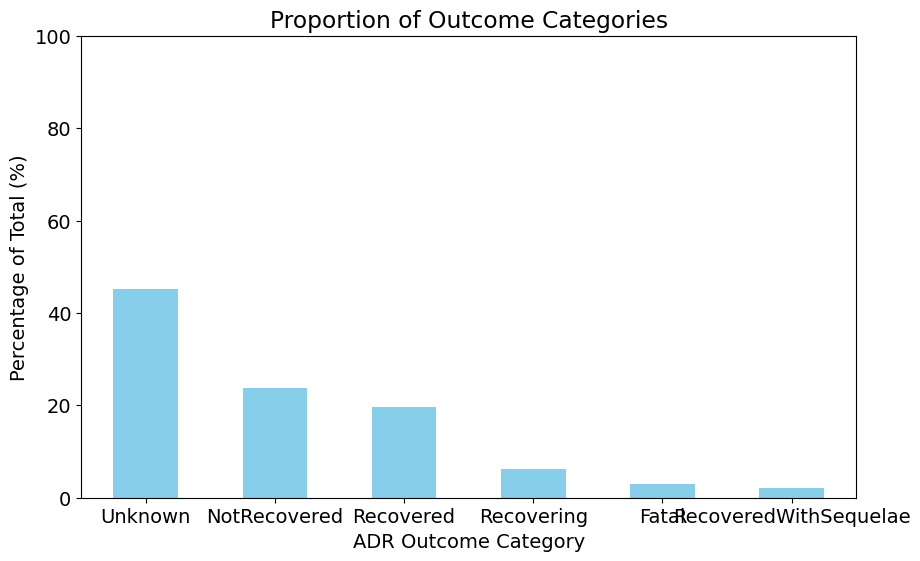

In [81]:
# Count the frequency of each category
category_counts = patient_reactions_table['outcome'].value_counts()

# Calculate the percentages
total = len(patient_reactions_table)
percentages = (category_counts / total) * 100

# Text size
plt.rcParams.update({'font.size': 14})

# Plotting the frequency bar plot
plt.figure(figsize=(10, 6))
bars = percentages.plot(kind='bar', color='skyblue')
plt.title('Proportion of Outcome Categories')
plt.xlabel('ADR Outcome Category')
plt.ylabel('Percentage of Total (%)')
plt.ylim(0, 100)
plt.xticks(rotation=0)

plt.show()

In [82]:
patient_reactions_table['outcome'].value_counts()

Unknown                  459
NotRecovered             242
Recovered                200
Recovering                63
Fatal                     31
RecoveredWithSequelae     21
Name: outcome, dtype: int64

In [83]:
patient_reactions_table['outcome'].value_counts(normalize=True)

Unknown                  0.451772
NotRecovered             0.238189
Recovered                0.196850
Recovering               0.062008
Fatal                    0.030512
RecoveredWithSequelae    0.020669
Name: outcome, dtype: float64

### Drop Unknowns (check if any "unknowns" overlap with 3 level outcome??) and Circular Analysis Outcomes

In [84]:
# Drop cases with "unknown" outcomes
patient_reactions_table = patient_reactions_table.loc[patient_reactions_table['outcome'] != 'Unknown']

In [85]:
# Drop reaction terms containing the word death or serious

# create row drop function to drop rows with reactions that meet criteria to drop


### Assess Text Field Lengths

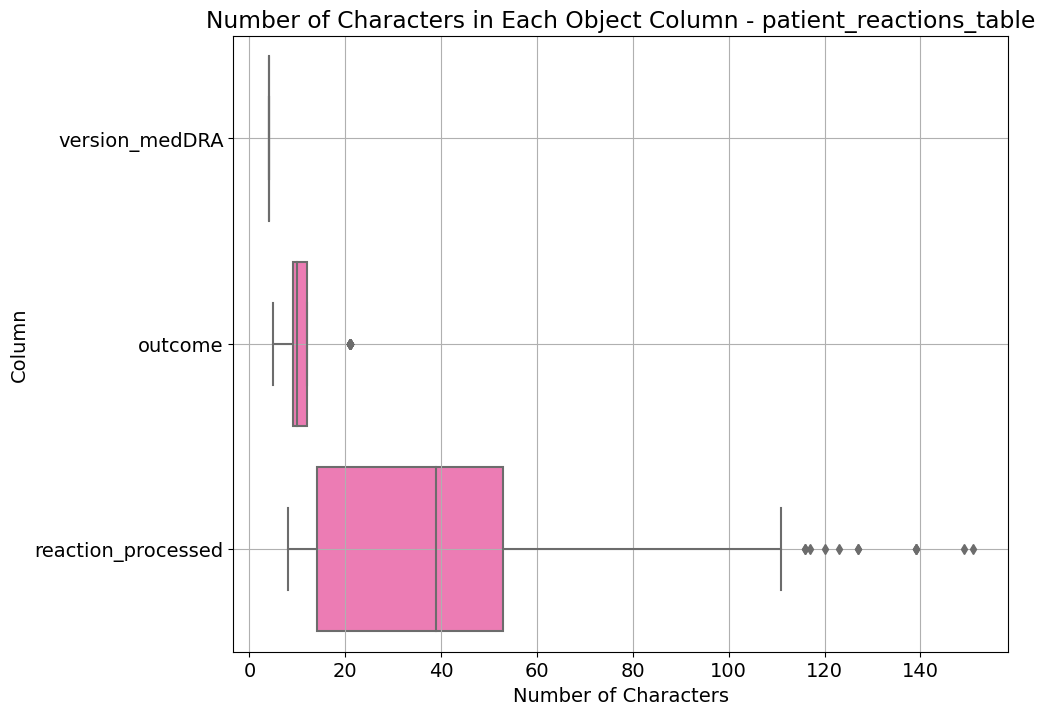


Descriptive Statistics on Character Length:
                    count       mean        std  min   25%   50%   75%    max
version_medDRA      557.0   4.000000   0.000000  4.0   4.0   4.0   4.0    4.0
outcome             557.0  10.646320   2.765189  5.0   9.0  10.0  12.0   21.0
reaction_processed  557.0  39.982047  27.947401  8.0  14.0  39.0  53.0  151.0


In [86]:
plot_character_length(patient_reactions_table, 'patient_reactions_table')

### Examine Outlier Text Lengths to Help with VARCHAR Limits

In [87]:
reactions_table_text_processed_outliers = examine_text_outliers(patient_reactions_table['reaction_processed'])
#print(reactions_table_text_processed_outliers)

#### Drop reaction_processed

In [88]:
patient_reactions_table = patient_reactions_table.drop(columns=['reaction_processed'])


In [89]:
# Write the DataFrame to a CSV file
patient_reactions_table.to_csv('DataLibrary/reactions_table.csv', index=False)

## PreProcess Prices Table

### Select Columns

In [117]:
prices_table = pd.DataFrame(prices_df, 
                            columns = [#"NDC Description",  # Identifies the drug name/dosage, Redundant Information with labels_table
                                       "NDC",  # 11 character FDA code, Do NOT Tokenize, database key
                                       "NADAC_Per_Unit",  #  The National Average Drug Acquisition Cost per unit, do NOT tokenize
                                       "Effective Date",  # The effective date of the NADAC Per Unit cost
                                        #"Pricing_Unit",  # Pricing unit for NDC ('ML', 'GM 'or 'EA'), Not necessary, just use price
                                        #"Pharmacy_Type_Indicator",  # 'C/I' data from Chain/Independent pharmacies, does not provide helpful info
                                        #"OTC",  # Indicates whether NDC is over-the-counter (OTC), redundant with labels_table
                                        #"Explanation Code",  # NADAC Calculation Method, not necessary for this project, too much missing data
                                                                       # Code 1: Inform from most recent survey.
                                                                       # Code 2: Cost within ± 2%, carried forward from previous
                                                                       # Code 3: Published pricing, or help desk inquiry
                                                                       # Code 4: Carried forward from previous year
                                                                       # Code 5: Based on package size.
                                                                       # Code 6: CMS Covered Outpatient Drug Product File drug category 
                                        "Classification_for_Rate_Setting",  # B: brand, 
                                                                            # G: generic
                                                                            # B-ANDA: brand under ANDA
                                                                            # B-BIO: biosimilar brand  
                                        #"Corresponding_Generic_Drug_NADAC_Per_Unit",
                                        #"Corresponding_Generic_Drug_Effective_Date"
                                        #"As of Date"
                                      ])

#prices_table = prices_table[['NDC', 'NADAC_Per_Unit', 'Effective Date', 'Classification_for_Rate_Setting', 
#                             'Corresponding_Generic_Drug_NADAC_Per_Unit', 'Corresponding_Generic_Drug_Effective_Date']]


NameError: name 'prices_df' is not defined

### Fix Dtypes

In [ ]:
prices_table['Effective Date'] = pd.to_datetime(prices_table['Effective Date'])
prices_table['year'] = prices_table['Effective Date'].dt.year
#prices_table['Corresponding_Generic_Drug_Effective_Date'] = pd.to_datetime(prices_table['Corresponding_Generic_Drug_Effective_Date'])
prices_table['NADAC_Per_Unit'] = prices_table['NADAC_Per_Unit'].astype(float)

### Examine Nulls

In [ ]:
# replace empty strings with nan
prices_table = prices_table.replace(r'^\s*$', np.nan, regex=True)

prices_nan = nan_info(prices_table)
prices_nan

### Feature Engineering 

In [ ]:
prices_table['Classification_for_Rate_Setting'].value_counts()

In [ ]:
# Update classification to binary generic/brand, G:1 B:0
prices_table['Classification_for_Rate_Setting'] = prices_table['Classification_for_Rate_Setting'].apply(lambda x: 1 if x == 'G' else 0)

In [ ]:
# Add index column
prices_table = add_sequential_index(prices_table, 'price_id')

### Rename Columns

In [ ]:
prices_table = prices_table.rename(columns = {'NDC': 'ndc11',
                         'NADAC_Per_Unit': 'unit_price',
                         'Effective Date': 'price_date',
                         'Classification_for_Rate_Setting': 'generic_brand',
                         'Corresponding_Generic_Drug_NADAC_Per_Unit': 'generic_price',
                         'Corresponding_Generic_Drug_Effective_Date': 'generic_date'})

In [ ]:
prices_table = prices_table[['ndc11',
                            'unit_price',
                            'year',
                            'generic_brand']]

In [ ]:
prices_table.info()

In [ ]:
# Write the DataFrame to a CSV file
prices_table.to_csv('DataLibrary/prices_table.csv', index=False)

## Preprocess Documents Table

### Select Columns

In [ ]:
documents_table = pd.DataFrame(documents_df, columns=["doc_type", "year", "text"])

documents_table = add_sequential_index(documents_table,'doc_id')


### Fix Dtypes

### Match Drugs Present in Text

In [ ]:
def find_matching_drugs(text, unique_drug_names):
    matched_drugs = []
    for drug in unique_drug_names:
        if drug.lower() in text.lower():
            matched_drugs.append(drug)
    return matched_drugs


#### Without MultiProcessing

In [ ]:
start_time = time.time()
# Create 'matching_drugs' column using apply
documents_table['matching_drugs'] = documents_table['text'].apply(lambda x: find_matching_drugs(x, unique_drug_names))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### With MultiProcessing

In [440]:
# Figure out how to apply
# Create a pool with the same number of workers as CPU cores

start_time = time.time()


if __name__ == '__main__':
    with mp.Pool(num_cores) as pool:
        documents_table['matching_drugs'] = pool.starmap(find_matching_drugs, zip(documents_table['text'], [unique_drug_names]*len(documents_table)))

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Process SpawnPoolWorker-177:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'find_matching_drugs' on <module '__main__' (built-in)>
Process SpawnPoolWorker-176:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky

KeyboardInterrupt: 

### Match Reactions Present in Text

In [ ]:
# Function to check for matches between text and unique_reactions
def check_reactions(text, unique_reactions):
    text_lower = text.lower()
    matches = [1 if reaction.lower() in text_lower else 0 for reaction in unique_reactions]
    return matches

In [ ]:
documents_table.head()

### Generate binary column for each reaction

In [444]:
# Apply the function across the dataframe to populate binary columns
documents_table[unique_reactions] = documents_table['text'].apply(lambda x: pd.Series(check_reactions(x, unique_reactions)))

# Text column no longer needed
documents_table.drop(columns=['text'], inplace=True)

# Function to return matching reactions as a list
def get_matching_reactions(row, unique_reactions):
    matching_reactions = [reaction for reaction in unique_reactions if row[reaction] == 1]
    return matching_reactions

# Create 'all_reactions' column by applying the function row-wise
documents_table['all_reactions'] = documents_table.apply(lambda row: get_matching_reactions(row, unique_reactions), axis=1)

documents_table.head()

,doc_id,doc_type,year,matching_drugs,off label use,fatigue,pyrexia,diarrhoea,nausea,dyspnoea,...,upper respiratory tract inflammation,foetal death,sensory disturbance,incontinence,foot fracture,autoimmune disorder,autoimmune hepatitis,localised oedema,peripheral coldness,all_reactions
0,1,pr,2014,"[health, body]",0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[fatigue, rash, infection, upper respiratory t..."
1,2,pr,2014,"[ibu, health, body]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."
2,3,pr,2013,[health],0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[mental disorder]
3,4,pr,2013,"[ibu, health]",0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,"[nausea, pain, headache, vomiting, abdominal p..."
4,5,pr,2014,"[ibu, health]",0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,[illness]


In [445]:
# apply parallel processing

### Explode Table by Reaction 

In [446]:
# Explode the dataframe based on reaction; makes a new row for each reaction in the list
documents_table = documents_table.explode('matching_drugs').reset_index(drop=True)

### Rename columns

In [447]:
documents_table.rename(columns={'matching_drugs': 'drug'}, inplace=True)
documents_table.head()

,doc_id,doc_type,year,drug,off label use,fatigue,pyrexia,diarrhoea,nausea,dyspnoea,...,upper respiratory tract inflammation,foetal death,sensory disturbance,incontinence,foot fracture,autoimmune disorder,autoimmune hepatitis,localised oedema,peripheral coldness,all_reactions
0,1,pr,2014,health,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[fatigue, rash, infection, upper respiratory t..."
1,1,pr,2014,body,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[fatigue, rash, infection, upper respiratory t..."
2,2,pr,2014,ibu,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."
3,2,pr,2014,health,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."
4,2,pr,2014,body,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[pain, insomnia, anxiety, chest pain, tachycar..."


### Fix Dtypes

In [448]:
numeric_columns = documents_table.drop(columns=['doc_id', 'doc_type', 'year', 'drug'])
numeric_columns = numeric_columns.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coerce errors to NaN

In [449]:
#documents_table.dtypes

### Drop all reactions column

In [450]:
documents_table.drop(columns=['all_reactions'], inplace=True)


### Add new additional id column

In [451]:
documents_table.head()
documents_table = add_sequential_index(documents_table, 'id')

### Save as CSV for Data Exploration

In [452]:
documents_table.to_csv('documents_table.csv', index=False)

## Preprocess Manufacturers Table

In [347]:
manus_df.columns

NameError: name 'manus_df' is not defined

### Select Columns

In [ ]:
# Choose values to help fill in missing data from other tables
manus_table = pd.DataFrame(manus_df, 
                           columns=["product_ndc",
                                    "generic_name",
                                    "brand_name",
                                    "openfda.manufacturer_name",
                                   "spl_id",
                                   "openfda.spl_set_id",
                                   "openfda.unii",
                                   "marketing_start_date"])  # Update to expiration date

### Feature Engineering

In [ ]:
manus_table = add_sequential_index(manus_table,'manu_id')

In [ ]:
manus_table['year'] = pd.to_datetime(manus_table['marketing_start_date']).dt.year

### Examine Nulls

In [ ]:
manus_nan = nan_info(manus_table)
manus_nan

### Fix Dtypes

### Text Processing

In [ ]:
manus_table['drug_names'] = manus_table['generic_name']+ " " + manus_table['brand_name']

In [ ]:
manus_table['drug_names_processed'] = manus_table['drug_names'].apply(process_label_text).apply(remove_duplicates_nan)
manus_table[['drug_names', 'drug_names_processed']].head(10)

In [ ]:
manus_table['manufacturers'] = manus_table['openfda.manufacturer_name'].apply(clean_manufacturer_text)
manus_table[['openfda.manufacturer_name', 'manufacturers']].head(10)

In [ ]:
manus_table_rxcui_outliers = examine_text_outliers(manus_table['manufacturers'])
print(manus_table_rxcui_outliers)

### Rename and Select Columns

In [ ]:
manus_table = manus_table.rename(columns = {'product_ndc': 'ndc',
                         'drug_names_processed': 'drug_names',
                         'openfda.spl_set_id': 'set_id',
                         'openfda.unii': 'unii'})

In [ ]:
manus_table = manus_table[['manu_id',
                           'spl_id',
                           'ndc',
                           'year',
                          'drug_names',
                          'set_id',
                          'unii',
                           'drug_names',
                          'manufacturers']]

### Assess Text Field Lenghts

In [ ]:
plot_character_length(manus_table, 'manus_table')

In [ ]:
# Write the DataFrame to a CSV file
#manus_table.to_csv('DataLibrary/manus_table.csv', index=False)

# Standardization and Normalization
* Use Parallel Processing

## Read in ADReCS Files

In [349]:
adrecs_drugs = pd.read_excel('ADReCS/Drug_information_v3.3.xlsx')
adrecs_drugs.head()

,DRUG_ID,DRUG_NAME,DRUG_SYNONYMS,DrugBank_ID,PubChem_ID,MESH_ID,KEGG_ID,TTD_ID
0,BADD_D00001,"1,2-hexanediol","1,2-hexanediol",DB14108,94335,C119102,Not Available,Not Available
1,BADD_D00002,2-hydroxy-3-phenylpropanoic acid,"3-phenyllactic acid | 3-phenyllactic acid, mon...",Not Available,3848,C017648,Not Available,Not Available
2,BADD_D00003,2-phenylbutyric acid,2-phenylbutyric acid | 2-phenylbutanoic acid,Not Available,7012,C039714,Not Available,Not Available
3,BADD_D00004,2-[1-methyl-5-(4-methylbenzoyl)pyrrol-2-yl]ace...,"Tolmetin | Tolectin | Tolmetin Sodium, Anhydro...",DB00500,5508,D014046,D00158; D02355,D09BHB
4,BADD_D00005,4-oxo-3-(3-oxo-1-phenylbutyl)chromen-2-olate,Warfarin | 4-Hydroxy-3-(3-oxo-1-phenylbutyl)-2...,DB00682,23690541,D014859,D00564; D08682; D01280,D0E3OF


In [350]:
adrecs_ont = pd.read_excel('ADReCS/ADR_ontology_v3.3.xlsx')
adrecs_ont.head()

,ADRECS_ID,ADR_ID,ADR_TERM,ADR_SYNONYMS,MEDDRA_CODE
0,01,BADD_A00503,Blood and lymphatic system disorders,Not Available,10005329
1,01.01,BADD_A06244,Coagulopathies and bleeding diatheses (excl th...,Not Available,10064477
2,01.01.01,BADD_A00960,Coagulation factor deficiencies,Not Available,10009737
3,01.01.01.001,BADD_A02211,Hypoprothrombinaemia,Exaggerated hypoprothrombinaemia | Hypoprothro...,10021085
4,01.01.01.002,BADD_A05294,Acquired haemophilia,Acquired haemophilia | Acquired hemophilia | A...,10053745


## Standardize Drug Names into Primary Ingredient Compounds
* Based on 90% string match between FAERS reported medicinal product and ADReCS classification data

In [351]:
# Reactions table test set
drugs_test = pd.read_csv('DataLibrary/drugs_table.csv').iloc[0:80, ]
drugs_test

,patient_drug_id,event_id,spl_set_id,indication,med_product,generic_name,manufacturers,manu_num,product_type,rxcui,rxcui_num,unii
0,1,1,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
1,2,2,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
2,3,3,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
3,4,4,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
4,5,5,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
5,6,6,"['113d92bf-f6c9-cc3d-e063-6294a90af033', '1319...","product, used, unknown, indication, product us...",acetaminophen,"acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
6,7,7,"['adc84ad5-a04d-4fee-9ba8-91f7abd928e3', 'd592...","chronic, myeloid, leukaemia, chronic myeloid, ...",bosutinib,bosutinib,"pfizer-laboratories-div-pfizer-, u-s-pharmaceu...",2,"human, prescription, drug, human prescription,...",1307624.0,7,844ZJE6I55
7,8,8,['17f85d17-ab71-4f5b-9fe3-0b8c822f69ff'],"breast, cancer, breast cancer",pertuzumab,pertuzumab,genentech,1,"human, prescription, drug, human prescription,...",1298948.0,7,K16AIQ8CTM
8,9,8,['17f85d17-ab71-4f5b-9fe3-0b8c822f69ff'],NaN,pertuzumab,pertuzumab,genentech,1,"human, prescription, drug, human prescription,...",1298948.0,7,K16AIQ8CTM
9,10,8,['17f85d17-ab71-4f5b-9fe3-0b8c822f69ff'],NaN,pertuzumab,pertuzumab,genentech,1,"human, prescription, drug, human prescription,...",1298948.0,7,K16AIQ8CTM


In [352]:
from pathos.multiprocessing import ProcessingPool as Pool
import pandas as pd
import numpy as np
import multiprocessing as mp
from fuzzywuzzy import process
import time

In [353]:
def process_and_normalize_drugs(df_chunk, df2_synonyms, df2_names):
    def drug_name_norms(row):
        med_product_list = str(row['med_product']).split(' \, ')
        med_product_list = list(set(med_product_list))  # unique values
        synonyms_list = list(set(' '.join(df2_synonyms).split(' \| ')))  # unique values
        match = process.extractOne(' '.join(med_product_list), synonyms_list)
        if match and match[1] > 90:
            original_row_index = df2_synonyms[df2_synonyms.str.contains(match[0], regex=False)].index
            if not original_row_index.empty:
                return df2_names.iloc[original_row_index[0]]
        return None

    df_chunk['drug_name_norm'] = df_chunk.apply(drug_name_norms, axis=1)
    return df_chunk

def parallel_worker(chunk, func, args):
    return func(chunk, *args)

def apply_parallel(df, func, args):
    df_split = np.array_split(df, mp.cpu_count())
    with mp.Pool(mp.cpu_count()) as pool:
        result = pd.concat(pool.starmap(parallel_worker, [(chunk, func, args) for chunk in df_split]))
    return result

if __name__ == '__main__':

    start_time = time.time()

    # Apply the parallel processing
    result_table = apply_parallel(drugs_test, process_and_normalize_drugs, (adrecs_drugs['DRUG_SYNONYMS'], adrecs_drugs['DRUG_NAME']))

    # Combine the result into a single column in the original table
    drugs_test['drug_name_norm'] = result_table['drug_name_norm']

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time} seconds")

Process SpawnPoolWorker-5:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/queues.py", line 358, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'parallel_worker' on <module '__main__' (built-in)>
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/vicky/opt/anaconda3/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/vicky/opt/ana

KeyboardInterrupt: 

In [354]:
drugs_test[['med_product', 'drug_name_norm']].head(10)

KeyError: "['drug_name_norm'] not in index"

### Create Drug Compound Binary Matrix

## Standardize Adverse Event Terms
* Based on an 80% string match with ADReCS ontology system

In [ ]:
# Reactions table test set
#reactions_test = pd.read_csv('DataLibrary/reactions_table.csv').iloc[0:5, ]
#reactions_test

In [ ]:
# Time Processing
#start_time = time.time()

# Function to find the best match and return the corresponding value
#def drug_adr_norms(row, df2_col2, df2_col3):
    # Ensure that med_product is a string
#    reaction_processed = str(row['reaction_processed'])
    # Split the synonyms and create a list
#    synonyms_list = df2_col2.str.split(' \| ').explode().unique()
    # Find the best match
#    match = process.extractOne(reaction_processed, synonyms_list)
#    if match and match[1] > 80:  # 80 is a threshold for matching confidence
        # Find the original row in df2_col2
#        original_row = df2_col2[df2_col2.str.contains(match[0], regex=False)]
#        if not original_row.empty:
#            return df2_col3[original_row.index[0]]
#    return None


# Apply the function to df1 to create the new column
#reactions_test['adr_norm'] = reactions_test.apply(drug_adr_norms, 
#                                                             args=(adrecs_ont['ADR_SYNONYMS'], 
#                                                                   adrecs_ont['ADR_TERM']), axis=1)

#end_time = time.time()
#execution_time = end_time - start_time
#print(execution_time)

### Create ADR Term Matrix

## Filling in Missing Data Across Tables - May be Able to Delete and Use RxNorm API retrieve

#### Create Smaller Samples for Testing 

In [ ]:
labels_test = pd.read_csv('DataLibrary/labels_table.csv').iloc[0:50,]
drugs_test = pd.read_csv('DataLibrary/drugs_table.csv').iloc[0:50,]

#### Remove punctuation from set_id, ndc codes, unii, to standardize across tables

In [ ]:
# Function to standardize NDC format
def remove_punctuation(s):
    return s.translate(str.maketrans('', '', string.punctuation))


# Apply to both dataframes
labels_test['ndc'] = labels_test['ndc'].astype(str).apply(remove_punctuation)
manus_table['ndc'] = manus_table['ndc'].astype(str).apply(remove_punctuation)
labels_test['set_id'] = labels_test['set_id'].astype(str).apply(remove_punctuation)
manus_table['set_id'] = manus_table['set_id'].astype(str).apply(remove_punctuation)


#### Check for matching NDC codes across sources

In [ ]:
def find_matches(list1, list2):

     # Convert inner lists to tuples to make them hashable
    set1 = set(tuple(x) if isinstance(x, list) else x for x in list1)
    set2 = set(tuple(x) if isinstance(x, list) else x for x in list2)
    
    # Find the intersection of the two sets
    common_elements = set1.intersection(set2)
    
    # Convert the set back to a list
    return list(common_elements)

list1 = manus_table['set_id'].tolist()
list2 = labels_test['set_id'].tolist()

matches = find_matches(list1, list2)
matches

### Manufacturer Table Contains 100% of NDC code for all actively marketed drugs
* Create dictionary pairs to map and fill in missing data for dictionary method

In [ ]:
# Fill in missing unii and spl_set_id with zeros to create dictionaries
manus_table['unii'] = manus_table['unii'].fillna(0)
manus_table['set_id'] = manus_table['set_id'].fillna(0)

In [ ]:
# Dictionary of ndc and spl_id
manu_ndc_spl_dict = dict(zip(manus_table['ndc'], manus_table['spl_id']))

In [ ]:
# Dictionary of ndc code and unii
manu_ndc_unii_dict = dict(zip(manus_table['ndc'], manus_table['unii']))

In [ ]:
# Dictionary of ndc code and spl_set_id
manu_ndc_set_dict = dict(zip(manus_table['ndc'],manus_table['set_id']))

### Using String Match Function Across DataFrames to Fill in Missing Data 

In [ ]:
# Data Prior to matching
labels_test.info()

In [ ]:
labels_test

In [ ]:
# Define string-match function
def match_ndc(df1, df2, df1_col1, df1_col2, df2_col1, df2_col2):
    def find_match(row):
        if row[df1_col1] == 'nan':
            set_id = row[df1_col2]
            match = process.extractOne(set_id, df2[df2_col2].astype(str).tolist())
            if match and match[1] == 90:  # 90 is a threshold for matching confidence
                matched_row = df2[df2[df2_col2].astype(str) == match[0]]
                if not matched_row.empty:
                    ndc_value = matched_row[df2_col1].values[0]
                    # If ndc_value is a list, return the first element, otherwise return the string
                    if isinstance(ndc_value, list):
                        return ndc_value[0]
                    else:
                        return ndc_value
        return row[df1_col1]
    
    df1[df1_col1] = df1.apply(find_match, axis=1)
    return df1

# Start timing
start_time = time.time()

# Using the function to fill in missing ndc values in df1
labels_test = match_ndc(labels_test, manus_table, 'ndc', 'set_id', 'ndc', 'set_id')

# End timing
end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time)

In [ ]:
# Check if data was filled in post-matching
labels_test.info()

In [ ]:
labels_test['ndc'].tolist()

In [ ]:
# Look up specific set_ids and ndc in manus_table to confirm proper matching


### Using Reverse Dictionary Mapping to Fill in Missing Data

In [ ]:
# Examine data before matching
labels_test

In [ ]:
# Time it
start_time = time.time()

# Create reverse mapping from set_id to ndc
reverse_mapping = {}
for ndc, set_ids in manu_ndc_set_dict.items():
    if isinstance(set_ids, list):
        for set_id in set_ids:
            reverse_mapping[set_id] = ndc

# Function to fill NaN values in 'ndc' based on 'set_id'
def fillna_ndc_with_setid(row, reverse_dict):
    if pd.isna(row['ndc']) and row['set_id'] in reverse_dict:
        return reverse_dict[row['set_id']]
    return row['ndc']

# Apply the function to fill NaN values in 'ndc'
labels_test['ndc'] = labels_test.apply(lambda row: fillna_ndc_with_setid(row, reverse_mapping), axis = 1)

In [ ]:
# Check if data was filled in post-matching
labels_test.info()

In [ ]:
labels_test

In [ ]:
manus_table.head()

In [ ]:
# Look up specific set_ids and ndc in manus_table to confirm proper matching
ndc_check = manus_table.loc[manus_table['set_id'] == "000155a8709c44e5a75fcd890f3a7caf", 'ndc'].values
ndc_check

### Generate Year Helper Table

In [ ]:
years = list(range(1900, 2051))
year_table = pd.DataFrame({'year': years})

# Combining Data into SQL Database Based on Keys

## Create new database to store data

In [252]:
# connect to MySQL server
connection = mysql.connector.connect(host="localhost", user="root", password=PASSWORD)

# Create a cursor object
cursor = connection.cursor()

# Drop the database if it exists - this is so we can start fresh (at least while developing)
cursor.execute("DROP DATABASE IF EXISTS pharma_db")

# Create the 'covid_db' database
cursor.execute("CREATE DATABASE pharma_db")

# Switch to the 'covid_db' database
cursor.execute("USE pharma_db")

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

### Create Read-Only User Access for Public

In [253]:
# public username and password

### Create Edit Privelages for Us

In [254]:
# private username and password

## Create datframes from API request dataframes

#### First remove all column  names with > 64 characters due to limit

Some unique reactions are too long

In [255]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

#--------------------------------------------------------------------------

#Create year table
create_year_query = """
CREATE TABLE IF NOT EXISTS `year` (
  `year` INT(4),
  PRIMARY KEY (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_year_query)


# Create documents table
documents_table_csv = pd.read_csv('documents_table.csv')

# Define specific columns and their data types
documents_specific_columns = {
    'id': 'INT NOT NULL',
    'doc_id': 'INT NOT NULL',
    'doc_type': 'VARCHAR(4)',
    'year': 'INT(4)',
    'drug': 'VARCHAR(100)'
}

# Generate column definitions for unspecified columns as BOOLEAN
column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in documents_table_csv.columns if col not in documents_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_documents_table_query = f"""
CREATE TABLE IF NOT EXISTS `documents` (
  {", ".join([f"`{col}` {documents_specific_columns.get(col, 'BOOL')}" for col in documents_table_csv.columns])},
  PRIMARY KEY(`id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""

cursor.execute(create_documents_table_query)
#----------------------------------------------------------------------
# Create adverse events table
create_events_query = """
CREATE TABLE IF NOT EXISTS `adverse_events` (
  `event_id` INT,
  `safetyreportid` VARCHAR(9),
  `year` INT(4),
  `serious_outcome` VARCHAR(10),
  `expedited` BOOLEAN,
  `report_source` INT,
  `country` VARCHAR(25),
  `age` INT,
  `sex` INT,
  `weight` INT,
  `company_name` VARCHAR(200),
  PRIMARY KEY (`event_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
) ENGINE=InnoDB;
"""
cursor.execute(create_events_query)

# Create patient_reactions table ------------------------

# Define specific columns and their data types

patient_reactions_specific_columns = {
 'patient_reaction_id': 'INT NOT NULL',
  'event_id' : 'INT',
  'version_medRNA' : 'VARCHAR(4)',
  'outcome': 'VARCHAR(50)'
}
  
#Generate column definitions for unspecified columns as BOOLEAN
patient_reactions_column_definitions = [
    f"`{re.sub(r'[^a-zA-Z0-9]', '_', col)}` BOOL"  # Replace non-alphanumeric characters with underscore
    for col in patient_reactions_table.columns if col not in patient_reactions_specific_columns
]

# Combine all column definitions into the CREATE TABLE query
create_patient_reactions_query = f"""
CREATE TABLE IF NOT EXISTS `patient_reactions` (
  {", ".join([f"`{col}` {patient_reactions_specific_columns.get(col, 'BOOL')}" for col in patient_reactions_table.columns])},
  PRIMARY KEY(`patient_reaction_id`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ON DELETE CASCADE,
  INDEX(`event_id`)
  ) ENGINE=InnoDB;
"""

cursor.execute(create_patient_reactions_query)

#-------------------------------------------

# Create labels table
create_labels_query = """
CREATE TABLE IF NOT EXISTS `labels` (
  `set_id` VARCHAR(100),
  `label_id` INT NOT NULL AUTO_INCREMENT,
  `year` INT(4),
  `ndc` VARCHAR(200), 
  `rxcui` VARCHAR(200),
  `unii` VARCHAR(150),
  `label_date` DATE,
  `ingredients` VARCHAR(5000),
  `warnings` TEXT(20000),
  `drug_names` VARCHAR(7500),
  `purpose` VARCHAR(2200),
  PRIMARY KEY(`label_id`),
  INDEX(`ndc`),
  INDEX(`rxcui`)
) ENGINE=InnoDB;
"""
cursor.execute(create_labels_query)

# Create patient_drugs table

#temporarily removed on delete cascade foreign key constraint for event_id for troubleshooting
create_patient_drugs_query = """
CREATE TABLE IF NOT EXISTS `patient_drugs` (
 `patient_drug_id` INT NOT NULL AUTO_INCREMENT,
  `event_id` INT,
  `med_product` VARCHAR(250),
  `indication` VARCHAR(150),
  `generic_name` VARCHAR(300),
  `manufacturers` VARCHAR(5000),
  `manu_num` INT,
  `product_type` VARCHAR(100),
  `rxcui` VARCHAR(760),
  `rxcui_num` INT,
  `unii` VARCHAR(150),
  PRIMARY KEY(`patient_drug_id`),
  INDEX(`event_id`),
  INDEX(`rxcui`),
  FOREIGN KEY (`event_id`) REFERENCES `adverse_events` (`event_id`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_patient_drugs_query)

create_prices_query = """
CREATE TABLE IF NOT EXISTS `prices` (
 `price_id` INT NOT NULL AUTO_INCREMENT,
  `ndc` VARCHAR(120),
  `unit_price` VARCHAR(20),
  `price_date` DATE,
  `generic_brand` BOOLEAN,
  `year` INT(4),
  PRIMARY KEY(`price_id`),
  FOREIGN KEY (`year`) REFERENCES `year` (`year`)
  ON DELETE CASCADE,
  INDEX(`ndc`)
) ENGINE=InnoDB;
"""
cursor.execute(create_prices_query)


# Create drug_names table
create_drug_names_query = """
CREATE TABLE IF NOT EXISTS `drug_names` (
  `drug_name_id` INT NOT NULL AUTO_INCREMENT,
  `label_id` INT,
  `rxcui` VARCHAR(100),
  `ndc` VARCHAR(60),
  `ingredients` VARCHAR(1000),
  PRIMARY KEY(`drug_name_id`),
  FOREIGN KEY (`ndc`) REFERENCES `labels` (`ndc`),
  FOREIGN KEY (`ndc`) REFERENCES `prices` (`ndc`),
  FOREIGN KEY (`rxcui`) REFERENCES `patient_drugs` (`rxcui`)
  ) ENGINE=InnoDB;
"""
cursor.execute(create_drug_names_query)

# show tables below
cursor.execute("SHOW TABLES")

# Fetch all the rows
tables = cursor.fetchall()

# Print the list of tables
for table in tables:
    print(table[0])

# Commit the changes
connection.commit()

# Close the cursor and connection
cursor.close()
connection.close()

adverse_events
documents
drug_names
labels
patient_drugs
patient_reactions
prices
year


## Bulk Import Data from Dataframes

### Year Table

#### Import data

In [256]:
years = list(range(1900, 2051))
year_table = pd.DataFrame({'year': years})

user = 'root'
password = PASSWORD
host = 'localhost'
database = 'pharma_db'
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}', echo=False)

year_table.to_sql('year', con=engine, if_exists='append', index=False)

-1

#### Preview Year Table

In [257]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM year LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,year
0,1900
1,1901
2,1902
3,1903
4,1904


### Documents Table

#### Import Data

In [258]:

start_time = time.time()

#read in csv
documents_table_csv = pd.read_csv('documents_table.csv')
documents_table_csv.to_sql('documents', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)
#documents_table.to_sql('documents', con=connection, if_exists='append', index=False)

21.265396118164062


#### Preview Documents Table

In [259]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM documents LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,id,doc_id,doc_type,year,drug,off label use,fatigue,pyrexia,diarrhoea,nausea,...,post procedural complication,upper respiratory tract inflammation,foetal death,sensory disturbance,incontinence,foot fracture,autoimmune disorder,autoimmune hepatitis,localised oedema,peripheral coldness
0,1,1,pr,2014,health,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,pr,2014,body,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,pr,2014,ibu,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,2,pr,2014,health,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,2,pr,2014,body,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Events Table

#### Import Data

In [260]:
start_time = time.time()

events_table_csv = pd.read_csv('DataLibrary/events_table.csv')
events_table_csv.to_sql('adverse_events', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.03416895866394043


#### Preview Events Table

In [261]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM adverse_events LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,event_id,safetyreportid,year,serious_outcome,expedited,report_source,country,age,sex,weight,company_name
0,1,None,2022,Serious,1,1,gb,None,2,67,perrigo
1,2,None,2022,Death,1,1,gb,None,2,49,perrigo
2,3,None,2022,Serious,1,1,gb,None,2,54,perrigo
3,4,None,2022,Serious,1,1,gb,None,2,60,perrigo
4,5,None,2022,Serious,1,1,gb,None,2,58,perrigo


### Patient Drugs Table

#### Import data

In [262]:
patient_drugs_table_csv = pd.read_csv('DataLibrary/patient_drugs_table.csv')
patient_drugs_table_csv = patient_drugs_table_csv.drop(columns=['spl_set_id'])
patient_drugs_table_csv.to_sql('patient_drugs', con=engine, if_exists='append', index=False)

-1

#### Preview Drugs Table

In [263]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_drugs LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,patient_drug_id,event_id,med_product,indication,generic_name,manufacturers,manu_num,product_type,rxcui,rxcui_num,unii
0,1,1,acetaminophen,"product, used, unknown, indication, product us...","acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
1,2,2,acetaminophen,"product, used, unknown, indication, product us...","acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
2,3,3,acetaminophen,"product, used, unknown, indication, product us...","acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
3,4,4,acetaminophen,"product, used, unknown, indication, product us...","acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."
4,5,5,acetaminophen,"product, used, unknown, indication, product us...","acetaminophen, tablet, extended, release, pain...","amazon-com-services-, meijer, hart-health, maj...",274,"human, otc, drug, prescription, human otc, otc...",313782.0,6,"362O9ITL9D, 9D2RTI9KYH, V9BI9B5YI2, 04JA59TNSJ..."


### Patient Reactions Table

In [264]:
patient_reactions_table.head()
#patient_reactions_table = patient_reactions_table.drop(columns=['reaction_processed'])


,patient_reaction_id,event_id,version_medDRA,outcome,nausea,arthralgia,fatigue,pain,vomiting,dyspnoea,...,helicobacter infection,cardiac arrest,blood test abnormal,psychiatric symptom,hyperhomocysteinaemia,blood pressure fluctuation,prescribed overdose,ankle fracture,carpal tunnel syndrome,goitre
0,1,1,24.1,Recovered,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,24.1,Recovered,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,4,2,24.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,2,24.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,6,2,24.1,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [265]:
start_time = time.time()
patient_reactions_table_csv = pd.read_csv('DataLibrary/reactions_table.csv')
patient_reactions_table_csv.to_sql('patient_reactions', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

4.796293258666992


#### Preview Patient Reactions Table

In [266]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM patient_reactions LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,patient_reaction_id,event_id,version_medDRA,outcome,nausea,arthralgia,fatigue,pain,vomiting,dyspnoea,...,helicobacter infection,cardiac arrest,blood test abnormal,psychiatric symptom,hyperhomocysteinaemia,blood pressure fluctuation,prescribed overdose,ankle fracture,carpal tunnel syndrome,goitre
0,1,1,24,Recovered,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,24,Recovered,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,4,2,24,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,5,2,24,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,6,2,24,Fatal,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Labels Table

#### Set Character Limits

#### Import Data

In [268]:
labels_table.head()

,set_id,label_id,year,ndc,rxcui,unii,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,72288-300,198440,[362O9ITL9D],"basic, care, acetaminophen, croscarmellose, so...",NaN,acetaminophen,"purpose, pain reliever, fever, reliever, relie..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,71020-016,1046593,[F5UM2KM3W7],"antibacterial, 2x, benzalkonium, chloride, wat...",NaN,"benzalkonium, chloride, benzalkonium chloride","purpose, purpose antibacterial, antibacterial"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,NaN,NaN,NaN,"truth, antibacterial, foaming, hand, wash, uns...",NaN,<NA>,"purpose, antimicrobial, purpose antimicrobial"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,NaN,NaN,NaN,"lithium, bromatum, bromide, sucrose, lactose, ...",NaN,<NA>,"relieve, symptom sleeplessness, relieve sympto..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,NaN,NaN,NaN,"iodoformum, iodoform, sucrose, lactose, white,...",NaN,<NA>,"relieve, cough, relieve symptom, us, symptom, ..."


In [327]:
start_time = time.time()

labels_table_csv = pd.read_csv('DataLibrary/labels_table.csv')
#labels_table_csv.drop(columns=['set_id'], inplace=True)

labels_table_csv.to_sql('labels', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

2.3713881969451904


#### Preview Labels Table

In [328]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM labels LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,set_id,label_id,year,ndc,rxcui,unii,label_date,ingredients,warnings,drug_names,purpose
0,00146b91-008d-4b16-95b0-6077f98821be,1,2022,72288-300,198440,362O9ITL9D,None,"basic, care, acetaminophen, croscarmellose, so...",None,acetaminophen,"purpose, pain reliever, fever, reliever, relie..."
1,00179db3-5a76-4724-a848-28e71eb580a6,2,2022,71020-016,1046593,F5UM2KM3W7,None,"antibacterial, 2x, benzalkonium, chloride, wat...",None,"benzalkonium, chloride, benzalkonium chloride","purpose, purpose antibacterial, antibacterial"
2,001aa754-65e3-4c5a-91f5-71a3d809be0c,3,2022,None,None,None,None,"truth, antibacterial, foaming, hand, wash, uns...",None,None,"purpose, antimicrobial, purpose antimicrobial"
3,001cc8c5-3b3b-456f-8b62-46da8202ea49,4,2022,None,None,None,None,"lithium, bromatum, bromide, sucrose, lactose, ...",None,None,"relieve, symptom sleeplessness, relieve sympto..."
4,001e5e85-ed03-4a0b-ae48-3a012882233a,5,2022,None,None,None,None,"iodoformum, iodoform, sucrose, lactose, white,...",None,None,"relieve, cough, relieve symptom, us, symptom, ..."


### Prices Table

#### Import Data

In [329]:
start_time = time.time()

prices_table_csv = pd.read_csv('DataLibrary/prices_table.csv')
prices_table_csv.to_sql('prices', con=engine, if_exists='append', index=False)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

0.7421350479125977


#### Preview Prices Table

In [330]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT * FROM prices LIMIT 5"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

,price_id,ndc,unit_price,price_date,generic_brand,year
0,1,24385005452,0.28255,None,1,2022
1,2,70000047501,0.28255,None,1,2022
2,3,46122038576,0.78326,None,1,2022
3,4,70000036201,0.15365,None,1,2022
4,5,70000036202,0.15365,None,1,2022
